## Analysis of the Quasiparticle Method from an analytical perspective

#### Analysis of the effective one-body matrix

Imports

In [1]:

from src.hamiltonian_utils import FermiHubbardHamiltonian
from src.nuclear_physics_utils import get_twobody_nuclearshell_model,SingleParticleState,QuadrupoleOperator,J2operator
import numpy as np
import torch
from typing import Dict
import scipy
from src.qml_models import AdaptVQEFermiHubbard
from src.qml_utils.train import Fit
from src.qml_utils.utils import configuration
from scipy.sparse.linalg import eigsh,expm_multiply
from tqdm import trange
import matplotlib.pyplot as plt
from src.utils_quasiparticle_approximation import QuasiParticlesConverterOnlynnpp,HardcoreBosonsBasis
from scipy.sparse import lil_matrix
file_name='data/usdb.nat'

SPS=SingleParticleState(file_name=file_name)

nparticles_a=2
nparticles_b=0

size_a=SPS.energies.shape[0]//2
size_b=SPS.energies.shape[0]//2

title=r'$^{18}$O'

/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


NSM Hamiltonian

In [2]:

# Compute the J^2 value
#J2Class=J2operator(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,single_particle_states=SPS.state_encoding,j_square_filename=file_name+'_j2',symmetries=[SPS.total_M_zero])

#Quadrupole Operator


# compute the NSM Hamiltonian
NSMHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
print('size=',size_a+size_b,size_b)
NSMHamiltonian.get_external_potential(external_potential=SPS.energies[:size_a+size_b])
if file_name=='data/cki':
    twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)

    NSMHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix)
else:
    NSMHamiltonian.twobody_operator=scipy.sparse.load_npz(f'data/nuclear_twobody_matrix/usdb_{nparticles_a}_{nparticles_b}.npz')
NSMHamiltonian.get_hamiltonian()

egs,psi0=NSMHamiltonian.get_spectrum(n_states=1)

print(egs)
print(NSMHamiltonian.basis)
print(NSMHamiltonian.hamiltonian)
print('total_m=',SPS.compute_m_exp_value(psi=psi0,basis=NSMHamiltonian.basis))

size= 24 12
[-11.93178825]
[[1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]]
  (0, 0)	-9.3151
  (0, 1)	0.6897999999999996
  (0, 2)	0.20328479938540372
  (0, 3)	-0.4062999999999996
  (0, 4)	-0.5082840208321855
  (0, 5)	0.18949464964372487
  (0, 6)	0.5082840208321854
  (0, 7)	0.18949464964372495
  (0, 8)	0.20328479938540372
  (0, 9)	-0

Quasiparticle Basis

In [3]:
QPC=QuasiParticlesConverterOnlynnpp()

QPC.initialize_shell(state_encoding=SPS.state_encoding)


#just for the basis
QPC.get_the_basis_matrix_transformation(basis=NSMHamiltonian.basis)

print(QPC.particles2quasiparticles.shape)
print(QPC.quasiparticle_basis)


(6, 14)
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


Get the effective Hamiltonian

In [4]:

hamiltonian_qq=QPC.particles2quasiparticles @ NSMHamiltonian.hamiltonian @ QPC.particles2quasiparticles.T
hamiltonian_rr=QPC.particles2restofstates @ NSMHamiltonian.hamiltonian @ QPC.particles2restofstates.T
hamiltonian_qr=QPC.particles2quasiparticles @ NSMHamiltonian.hamiltonian @ QPC.particles2restofstates.T
hamiltonian_rq=QPC.particles2restofstates @ NSMHamiltonian.hamiltonian @ QPC.particles2quasiparticles.T


values,psi=eigsh(hamiltonian_qq,k=1)
e0=values[0]

print(values[0])
values,psi=eigsh(hamiltonian_qq+(1/e0)*hamiltonian_qr @ hamiltonian_rq,k=1)

e1=values[0]

values,psi=eigsh(hamiltonian_qq+(1/e1)*hamiltonian_qr @ hamiltonian_rq+(1/e1**2)*hamiltonian_qr @ hamiltonian_rr @ hamiltonian_rq,k=1)

e2=values[0]
values,psi=eigsh(hamiltonian_qq+(1/e2)*hamiltonian_qr @ hamiltonian_rq+(1/e2**2)*hamiltonian_qr @ hamiltonian_rr @ hamiltonian_rq+(1/e2**3)*hamiltonian_qr @ hamiltonian_rr @ hamiltonian_rr @ hamiltonian_rq,k=1)


print(values[0],np.abs((values[0]-egs[0])/egs[0]))

print(hamiltonian_qq)

-11.931788251561525
-11.931788251561523 5.95503977090032e-16
  (0, 0)	-9.3151
  (0, 1)	0.6897999999999996
  (0, 2)	-0.4062999999999996
  (0, 3)	-0.900781889989654
  (0, 4)	-1.9314456782406446
  (0, 5)	0.6017349640876247
  (1, 0)	0.6897999999999996
  (1, 1)	-8.8615
  (1, 2)	0.8598999999999998
  (1, 3)	0.900781889989654
  (1, 4)	1.1336192497488327
  (1, 5)	-1.3995613925794368
  (2, 0)	-0.4062999999999996
  (2, 1)	0.8598999999999998
  (2, 2)	-9.145
  (2, 3)	-0.900781889989654
  (2, 4)	-0.7347060355029268
  (2, 5)	1.7984746068253425
  (3, 0)	-0.900781889989654
  (3, 1)	0.900781889989654
  (3, 2)	-0.900781889989654
  (3, 3)	-8.107099999999999
  (3, 4)	-0.7177133829043456
  (3, 5)	0.7177133829043456
  (4, 0)	-1.9314456782406446
  (4, 1)	1.1336192497488327
  (4, 2)	-0.7347060355029268
  (4, 3)	-0.7177133829043456
  (4, 4)	3.2251000000000003
  (4, 5)	0.9008999999999998
  (5, 0)	0.6017349640876247
  (5, 1)	-1.3995613925794368
  (5, 2)	1.7984746068253425
  (5, 3)	0.7177133829043456
  (5, 4)	0.90

Get the effective coupling

In [5]:
twobody_qq=QPC.particles2quasiparticles @ NSMHamiltonian.twobody_operator @ QPC.particles2quasiparticles.T
twobody_qr=QPC.particles2quasiparticles @ NSMHamiltonian.twobody_operator @ QPC.particles2restofstates.T
twobody_rq=QPC.particles2restofstates @ NSMHamiltonian.twobody_operator @ QPC.particles2quasiparticles.T
twobody_rr=QPC.particles2restofstates @ NSMHamiltonian.twobody_operator @ QPC.particles2restofstates.T

#print(twobody_qq)
print(twobody_qr)

external_potential_qq=QPC.particles2quasiparticles @ NSMHamiltonian.external_potential @ QPC.particles2quasiparticles.T

print(external_potential_qq)



  (0, 0)	0.20328479938540372
  (0, 1)	-0.5082840208321855
  (0, 2)	0.18949464964372487
  (0, 3)	0.5082840208321854
  (0, 4)	0.18949464964372495
  (0, 5)	0.20328479938540372
  (0, 6)	0.48367995370807726
  (0, 7)	0.48367995370807726
  (1, 0)	0.30763695987708084
  (1, 1)	-0.10165680416643715
  (1, 2)	0.6918637014569979
  (1, 3)	0.10165680416643713
  (1, 4)	0.691863701456998
  (1, 5)	0.30763695987708073
  (1, 6)	0.09673599074161551
  (1, 7)	0.09673599074161551
  (2, 0)	0.10435216049167703
  (2, 1)	0.4066272166657483
  (2, 2)	0.502369051813273
  (2, 3)	-0.4066272166657482
  (2, 4)	0.502369051813273
  (2, 5)	0.104352160491677
  (2, 6)	-0.3869439629664618
  (2, 7)	-0.3869439629664618
  (4, 0)	0.23293633710277395
  (4, 1)	-0.15865000000000007
  (4, 2)	-0.09509586140912163
  (4, 3)	0.15865000000000004
  (4, 4)	-0.09509586140912159
  (4, 5)	0.232936337102774
  (4, 6)	0.17470000000000002
  (4, 7)	0.17470000000000002
  (5, 0)	0.23293633710277395
  (5, 1)	-0.15865000000000007
  (5, 2)	-0.0950958614

Build $H_{qq}$ using qubits

In [6]:
QubitBasis=HardcoreBosonsBasis(basis=QPC.quasiparticle_basis)

h_qq=0.
for i in range(len(QPC.couples)//2): #just n-n 
    for j in range(len(QPC.couples)//2):
        
        h_qq+=hamiltonian_qq[i,j]*QubitBasis.adag_a_matrix(i,j)
        




one_body={}
for i,b in enumerate(QPC.quasiparticle_basis):
    for j,d in enumerate(QPC.quasiparticle_basis):
        idx_b=np.nonzero(b)[0]
        idx_d=np.nonzero(d)[0]
        print(idx_d,idx_b)
        one_body[(idx_b[0],idx_d[0])]=hamiltonian_qq[i,j]
        one_body[(idx_b[0]+len(QPC.couples)//2,idx_d[0]+len(QPC.couples)//2)]=hamiltonian_qq[i,j]

print(one_body.keys())

[0] [0]
[1] [0]
[2] [0]
[3] [0]
[4] [0]
[5] [0]
[0] [1]
[1] [1]
[2] [1]
[3] [1]
[4] [1]
[5] [1]
[0] [2]
[1] [2]
[2] [2]
[3] [2]
[4] [2]
[5] [2]
[0] [3]
[1] [3]
[2] [3]
[3] [3]
[4] [3]
[5] [3]
[0] [4]
[1] [4]
[2] [4]
[3] [4]
[4] [4]
[5] [4]
[0] [5]
[1] [5]
[2] [5]
[3] [5]
[4] [5]
[5] [5]
dict_keys([(0, 0), (6, 6), (0, 1), (6, 7), (0, 2), (6, 8), (0, 3), (6, 9), (0, 4), (6, 10), (0, 5), (6, 11), (1, 0), (7, 6), (1, 1), (7, 7), (1, 2), (7, 8), (1, 3), (7, 9), (1, 4), (7, 10), (1, 5), (7, 11), (2, 0), (8, 6), (2, 1), (8, 7), (2, 2), (8, 8), (2, 3), (8, 9), (2, 4), (8, 10), (2, 5), (8, 11), (3, 0), (9, 6), (3, 1), (9, 7), (3, 2), (9, 8), (3, 3), (9, 9), (3, 4), (9, 10), (3, 5), (9, 11), (4, 0), (10, 6), (4, 1), (10, 7), (4, 2), (10, 8), (4, 3), (10, 9), (4, 4), (10, 10), (4, 5), (10, 11), (5, 0), (11, 6), (5, 1), (11, 7), (5, 2), (11, 8), (5, 3), (11, 9), (5, 4), (11, 10), (5, 5), (11, 11)])


#### Proton-Neutron Case

Imports

In [7]:

from src.hamiltonian_utils import FermiHubbardHamiltonian
from src.nuclear_physics_utils import get_twobody_nuclearshell_model,SingleParticleState,QuadrupoleOperator,J2operator
import numpy as np
import torch
from typing import Dict
import scipy
from src.qml_models import AdaptVQEFermiHubbard
from src.qml_utils.train import Fit
from src.qml_utils.utils import configuration
from scipy.sparse.linalg import eigsh,expm_multiply
from tqdm import trange
import matplotlib.pyplot as plt
from src.utils_quasiparticle_approximation import QuasiParticlesConverter,HardcoreBosonsBasis
file_name='data/usdb.nat'

SPS=SingleParticleState(file_name=file_name)

nparticles_a=2
nparticles_b=2

size_a=SPS.energies.shape[0]//2
size_b=SPS.energies.shape[0]//2

title=r'$^{20}$O'

#### NSM Hamiltonian

In [8]:

file_name='data/usdb.nat'

SPS=SingleParticleState(file_name=file_name)

nparticles_a=2
nparticles_b=2

size_a=SPS.energies.shape[0]//2
size_b=SPS.energies.shape[0]//2

title=r'$^{20}$Ne'

# Compute the J^2 value
#J2Class=J2operator(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,single_particle_states=SPS.state_encoding,j_square_filename=file_name+'_j2',symmetries=[SPS.total_M_zero])

#Quadrupole Operator


# compute the NSM Hamiltonian
NSMHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
print('size=',size_a+size_b,size_b)
NSMHamiltonian.get_external_potential(external_potential=SPS.energies[:size_a+size_b])
if file_name=='data/cki':
    twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)

    NSMHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix)
else:
    NSMHamiltonian.twobody_operator=scipy.sparse.load_npz(f'data/nuclear_twobody_matrix/usdb_{nparticles_a}_{nparticles_b}.npz')
NSMHamiltonian.get_hamiltonian()

egs,psi0ne20=NSMHamiltonian.get_spectrum(n_states=1)

print(egs)

print('total_m=',SPS.compute_m_exp_value(psi=psi0ne20,basis=NSMHamiltonian.basis))

print(NSMHamiltonian.hamiltonian.shape)

size= 24 12
[-41.39649007]
total_m= [2.03287907e-20]
(640, 640)


Quasiparticle Basis

In [9]:
QPC=QuasiParticlesConverterOnlynnpp()

QPC.initialize_shell(state_encoding=SPS.state_encoding)


#just for the basis
QPC.get_the_basis_matrix_transformation(basis=NSMHamiltonian.basis)
for b in QPC.quasiparticle_basis:
    if np.sum(b)!=2:
        print(np.sum(b),'\n')

print(QPC.quasiparticle_basis.shape)
print(QPC.rest_basis.shape)


rest_basis_ne20=QPC.rest_basis.copy()
quasiparticle_basis_ne20=QPC.quasiparticle_basis.copy()

(36, 12)
(604, 24)


Get the effective Hamiltonian

In [10]:
twobody_qq=QPC.particles2quasiparticles @ NSMHamiltonian.twobody_operator @ QPC.particles2quasiparticles.T
twobody_qr=QPC.particles2quasiparticles @ NSMHamiltonian.twobody_operator @ QPC.particles2restofstates.T
twobody_rq=QPC.particles2restofstates @ NSMHamiltonian.twobody_operator @ QPC.particles2quasiparticles.T
twobody_rr=QPC.particles2restofstates @ NSMHamiltonian.twobody_operator @ QPC.particles2restofstates.T

#print(twobody_qq)
print(twobody_qq)

external_potential_qq=QPC.particles2quasiparticles @ NSMHamiltonian.external_potential @ QPC.particles2quasiparticles.T

print(external_potential_qq)

  (0, 0)	-14.51434603174604
  (0, 1)	0.6897999999999995
  (0, 2)	-0.4062999999999996
  (0, 3)	-0.9007818899896537
  (0, 4)	-1.9314456782406437
  (0, 5)	0.6017349640876244
  (0, 6)	0.6897999999999996
  (0, 12)	-0.4062999999999996
  (0, 18)	-0.900781889989654
  (0, 24)	-1.9314456782406446
  (0, 30)	0.6017349640876247
  (1, 0)	0.6897999999999995
  (1, 1)	-9.485076190476194
  (1, 2)	0.8598999999999996
  (1, 3)	0.9007818899896537
  (1, 4)	1.133619249748832
  (1, 5)	-1.3995613925794361
  (1, 7)	0.6897999999999996
  (1, 13)	-0.4062999999999996
  (1, 19)	-0.900781889989654
  (1, 25)	-1.9314456782406446
  (1, 31)	0.6017349640876247
  (2, 0)	-0.4062999999999996
  (2, 1)	0.8598999999999996
  (2, 2)	-8.407544444444449
  :	:
  (33, 33)	-8.029499999999999
  (33, 34)	-0.7177133829043454
  (33, 35)	0.7177133829043454
  (34, 4)	0.6017349640876247
  (34, 10)	-1.3995613925794368
  (34, 16)	1.7984746068253425
  (34, 22)	0.7177133829043456
  (34, 28)	0.9008999999999998
  (34, 30)	-1.9314456782406437
  (34,

In [11]:
hamiltonian_qq=QPC.particles2quasiparticles @ NSMHamiltonian.hamiltonian @ QPC.particles2quasiparticles.T
hamiltonian_rr=QPC.particles2restofstates @ NSMHamiltonian.hamiltonian @ QPC.particles2restofstates.T
hamiltonian_qr=QPC.particles2quasiparticles @ NSMHamiltonian.hamiltonian @ QPC.particles2restofstates.T
hamiltonian_rq=QPC.particles2restofstates @ NSMHamiltonian.hamiltonian @ QPC.particles2quasiparticles.T
external_potential_qq=QPC.particles2quasiparticles @ NSMHamiltonian.external_potential @ QPC.particles2quasiparticles.T

twobody_qq=QPC.particles2quasiparticles @ NSMHamiltonian.twobody_operator @ QPC.particles2quasiparticles.T
twobody_qr=QPC.particles2quasiparticles @ NSMHamiltonian.twobody_operator @ QPC.particles2restofstates.T
twobody_rq=QPC.particles2restofstates @ NSMHamiltonian.twobody_operator @ QPC.particles2quasiparticles.T
twobody_rr=QPC.particles2restofstates @ NSMHamiltonian.twobody_operator @ QPC.particles2restofstates.T

#print(twobody_qq)
#print(twobody_qr)

external_potential_qq=QPC.particles2quasiparticles @ NSMHamiltonian.external_potential @ QPC.particles2quasiparticles.T
QubitBasis=HardcoreBosonsBasis(basis=QPC.quasiparticle_basis)
h_qq=0.
print(one_body.keys())
for key,value in one_body.items():
    idx_a,idx_b=key

    h_qq+=value*QubitBasis.adag_a_matrix(idx_a,idx_b)

#### twobody terms
twobody_nnpp={}
for i,b in enumerate(QPC.quasiparticle_basis):
    for j,d in enumerate(QPC.quasiparticle_basis):
        idx_a,idx_b=np.nonzero(b)[0]
        idx_c,idx_d=np.nonzero(d)[0]
        if hamiltonian_qq[i,j]-h_qq[i,j]!=0.:
            twobody_nnpp[(idx_a,idx_b,idx_c,idx_d)]=hamiltonian_qq[i,j]-h_qq[i,j]


for key,value in twobody_nnpp.items():
    idx_a,idx_b,idx_c,idx_d=key

    h_qq+=value*QubitBasis.adag_adag_a_a_matrix(idx_a,idx_b,idx_c,idx_d)

h_qq_only_twobody=0.
for key,value in twobody_nnpp.items():
    idx_a,idx_b,idx_c,idx_d=key

    h_qq_only_twobody+=value*QubitBasis.adag_adag_a_a_matrix(idx_a,idx_b,idx_c,idx_d)

value,_=eigsh(h_qq,k=1)

print(value)

value,_=eigsh(h_qq_only_twobody,k=1)

print('only two body=',value)

print('norm ham_rr=',scipy.sparse.linalg.norm(hamiltonian_rr))
value,_=eigsh(hamiltonian_rr,k=1)
print(values[0])
print(hamiltonian_rr.shape)

hamiltonian_ne20_qq=hamiltonian_qq.copy()

dict_keys([(0, 0), (6, 6), (0, 1), (6, 7), (0, 2), (6, 8), (0, 3), (6, 9), (0, 4), (6, 10), (0, 5), (6, 11), (1, 0), (7, 6), (1, 1), (7, 7), (1, 2), (7, 8), (1, 3), (7, 9), (1, 4), (7, 10), (1, 5), (7, 11), (2, 0), (8, 6), (2, 1), (8, 7), (2, 2), (8, 8), (2, 3), (8, 9), (2, 4), (8, 10), (2, 5), (8, 11), (3, 0), (9, 6), (3, 1), (9, 7), (3, 2), (9, 8), (3, 3), (9, 9), (3, 4), (9, 10), (3, 5), (9, 11), (4, 0), (10, 6), (4, 1), (10, 7), (4, 2), (10, 8), (4, 3), (10, 9), (4, 4), (10, 10), (4, 5), (10, 11), (5, 0), (11, 6), (5, 1), (11, 7), (5, 2), (11, 8), (5, 3), (11, 9), (5, 4), (11, 10), (5, 5), (11, 11)])
[-32.20884586]
only two body= [-12.8192]
norm ham_rr= 396.6653601215977
-11.931788251561523
(604, 604)


In [12]:
nsteps_iteration=20
single_term = hamiltonian_rq  # Start with initial term
approximations=[]
for i in trange(nsteps_iteration):
    if i > 0:
        single_term = hamiltonian_rr @ single_term  # Efficient update
    approximations.append(hamiltonian_qr @ single_term)  # Store result
    
    
tot_hamiltonian=hamiltonian_qq
values,psi=eigsh(hamiltonian_qq,k=1)
e=values[0]
approximations=[]
nsteps_iteration=30
single_term = hamiltonian_rq  # Start with initial term
for i in trange(nsteps_iteration):
    if i > 0:
        single_term =hamiltonian_rr @ single_term  # Efficient update
    update=(hamiltonian_qr @ single_term)

    approximations.append(update)  # Store result
    
history_errors_exact=[]
for i in trange(nsteps_iteration):
    
    tot_hamiltonian=hamiltonian_qq
    delta_hamiltonian=0.
    for j in range(i):
        delta_hamiltonian=delta_hamiltonian+approximations[j]/e**(j+1)
    values,psi=eigsh(hamiltonian_qq+delta_hamiltonian,k=1)
    e=values[0]
    print(e)
    print(np.abs((e-egs[0])/egs[0]),'index=',i)
    history_errors_exact.append(np.abs((e-egs[0])/egs[0]))

100%|██████████| 30/30 [00:00<00:00, 224.33it/s]

-32.208845860000004
0.22194258973317726 index= 0
-34.3192599167688
0.17096208261604864 index= 1
-36.121551948394895
0.12742476753289558 index= 2
-37.45880480565919
0.09512123515804856 index= 3
-38.41745070899185
0.0719635736835586 index= 4
-39.11324127389526
0.05515561330615319 index= 5
-39.62517873384162
0.04278892571865701 index= 6
-40.00833174513002
0.03353323735916771 index= 7
-40.29889065311417
0.026514311177871036 index= 8
-40.522261465130214
0.021118423467959793 index= 9
-40.69565638978867
0.01692978514730788 index= 10
-40.83170395421686
0.013643333465300575 index= 11
-40.93914746980148
0.01104785941916123 index= 12
-41.024763330381205
0.00897966812010101 index= 13
-41.0932248218234
0.0073258686959909785 index= 14
-41.14844489107951
0.0059919375061894915 index= 15
-41.19297671445518
0.004916198396482254 index= 16
-41.22927235909498
0.00403941766999621 index= 17
-41.25867331179442
0.003329189516645555 index= 18
-41.28289905483008
0.002743977026572226 index= 19
-41.302498867746245

In [13]:
print(delta_hamiltonian)

  (0, 35)	-0.04538065209837732
  (0, 33)	0.06754584844077316
  (0, 32)	0.13597781870159695
  (0, 30)	0.3579299960060019
  (0, 28)	-0.4680065592918933
  (0, 25)	0.4203599652861566
  (0, 24)	-1.064089489088752
  (0, 23)	0.0675458484407732
  (0, 21)	-0.3743096221630461
  (0, 20)	-0.15852477616135466
  (0, 18)	-0.9205205546026359
  (0, 17)	0.135977818701597
  (0, 5)	0.35792999600600195
  (0, 15)	-0.15852477616135466
  (0, 3)	-0.9205205546026358
  (0, 14)	-0.02495841465183695
  (0, 12)	-0.6170599013660647
  (0, 2)	-0.6170599013660647
  (0, 10)	0.4203599652861568
  (0, 4)	-1.064089489088752
  (0, 7)	-0.10115127429185192
  (0, 6)	0.5360416726470066
  (0, 1)	0.5360416726470065
  (0, 0)	-1.6706095124406088
  (0, 13)	0.05170325131985802
  :	:
  (35, 13)	0.19864198513445647
  (35, 14)	-0.5186635628526619
  (35, 23)	0.22829329380513855
  (35, 29)	0.11251266390813097
  (35, 17)	0.603428502139957
  (35, 33)	0.22829329380513852
  (35, 9)	0.11855024707845661
  (35, 32)	0.603428502139957
  (35, 8)	0.19

Get the effective (p-p)--(n-n) interaction

In [14]:




tot_hamiltonian=hamiltonian_qq
values,psi=eigsh(hamiltonian_qq,k=1)
e=values[0]
approximations=[]
off_diagonal_hamiltonians_rr=[]
nsteps_iteration=30
single_term = hamiltonian_rq  # Start with initial term
rq_correction=hamiltonian_rq.copy()
qr_correction=hamiltonian_qr.copy()
for i in trange(nsteps_iteration):
    if i > 0:
        single_term = hamiltonian_rr @ single_term  # Efficient update
    approximations.append(hamiltonian_qr @ single_term)  # Store result
    


two_body_corrections=[]
for operator in approximations:
    twobody_term={}
    for i,b in enumerate(QPC.quasiparticle_basis):
        for j,d in enumerate(QPC.quasiparticle_basis):
            idx_a,idx_b=np.nonzero(b)[0]
            idx_c,idx_d=np.nonzero(d)[0]
            
            twobody_term[(idx_a,idx_b,idx_c,idx_d)]=operator[i,j]#-external_potential_qq[i,j]
    two_body_corrections.append(twobody_term)


# mean_field_hamiltonian=[]
# twoparticle_virtual_process_basis=QPC.rest_basis.copy()
# mean_field_hamiltonian=lil_matrix((twoparticle_virtual_process_basis.shape[0],twoparticle_virtual_process_basis.shape[0]))
# for i,b in enumerate(twoparticle_virtual_process_basis):
#     idx_a,idx_b,idx_c,idx_d=np.nonzero(b)[0]
    
#     count=0
#     for j,d in enumerate(QPC.rest_basis):
#         jdx_a,jdx_b,jdx_c,jdx_d=np.nonzero(d)[0]
#         if np.isclose(d[idx_a]*d[idx_b]*d[idx_c]*d[idx_d],1.):

#             mean_field_hamiltonian[i,i]+=hamiltonian_rr[j,j]
#             count+=1
        
#     mean_field_hamiltonian[i,i]=mean_field_hamiltonian[i,i]/count

# print(mean_field_hamiltonian)
# print('difference=',hamiltonian_rr-off_diagonal_hamiltonians_rr-mean_field_hamiltonian)

#### using this mean field algorithm



100%|██████████| 30/30 [00:00<00:00, 238.91it/s]


In [15]:

twobody_term_last_correction={}
for i,b in enumerate(QPC.quasiparticle_basis):
    for j,d in enumerate(QPC.quasiparticle_basis):
        idx_a,idx_b=np.nonzero(b)[0]
        idx_c,idx_d=np.nonzero(d)[0]
        
        twobody_term_last_correction[(idx_a,idx_b,idx_c,idx_d)]=delta_hamiltonian[i,j]#-external_potential_qq[i,j]


In [16]:
print(twobody_term_last_correction)

{(0, 6, 0, 6): -1.6706095124406088, (0, 6, 0, 7): 0.5360416726470065, (0, 6, 0, 8): -0.6170599013660647, (0, 6, 0, 9): -0.9205205546026358, (0, 6, 0, 10): -1.064089489088752, (0, 6, 0, 11): 0.35792999600600195, (0, 6, 1, 6): 0.5360416726470066, (0, 6, 1, 7): -0.10115127429185192, (0, 6, 1, 8): 0.05170325131985801, (0, 6, 1, 9): 0.1289081030568133, (0, 6, 1, 10): 0.4203599652861568, (0, 6, 1, 11): -0.05531298834769158, (0, 6, 2, 6): -0.6170599013660647, (0, 6, 2, 7): 0.05170325131985802, (0, 6, 2, 8): -0.02495841465183695, (0, 6, 2, 9): -0.15852477616135466, (0, 6, 2, 10): -0.2059801269657111, (0, 6, 2, 11): 0.135977818701597, (0, 6, 3, 6): -0.9205205546026359, (0, 6, 3, 7): 0.1289081030568133, (0, 6, 3, 8): -0.15852477616135466, (0, 6, 3, 9): -0.3743096221630461, (0, 6, 3, 10): -0.2777891669636472, (0, 6, 3, 11): 0.0675458484407732, (0, 6, 4, 6): -1.064089489088752, (0, 6, 4, 7): 0.4203599652861566, (0, 6, 4, 8): -0.20598012696571105, (0, 6, 4, 9): -0.2777891669636472, (0, 6, 4, 10): -

#### Two-body term (nn)--(nn)

In [17]:
file_name='data/usdb.nat'

SPS=SingleParticleState(file_name=file_name)

nparticles_a=4
nparticles_b=0

size_a=SPS.energies.shape[0]//2
size_b=SPS.energies.shape[0]//2

title=r'$^{20}$O'

# Compute the J^2 value
#J2Class=J2operator(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,single_particle_states=SPS.state_encoding,j_square_filename=file_name+'_j2',symmetries=[SPS.total_M_zero])

#Quadrupole Operator


# compute the NSM Hamiltonian
NSMHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
print('size=',size_a+size_b,size_b)
NSMHamiltonian.get_external_potential(external_potential=SPS.energies[:size_a+size_b])
if file_name=='data/cki':
    twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)

    NSMHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix)
else:
    NSMHamiltonian.twobody_operator=scipy.sparse.load_npz(f'data/nuclear_twobody_matrix/usdb_{nparticles_a}_{nparticles_b}.npz')
NSMHamiltonian.get_hamiltonian()

egs,psi0=NSMHamiltonian.get_spectrum(n_states=1)

print(egs)

print('total_m=',SPS.compute_m_exp_value(psi=psi0,basis=NSMHamiltonian.basis))

size= 24 12
[-23.93429271]
total_m= [-1.11239143e-16]


Pairing Hamiltonian one-body term

In [18]:
QPC=QuasiParticlesConverterOnlynnpp()

QPC.initialize_shell(state_encoding=SPS.state_encoding)


#just for the basis
QPC.get_the_basis_matrix_transformation(basis=NSMHamiltonian.basis)

print(QPC.particles2quasiparticles.shape)
print(QPC.quasiparticle_basis)

print(QPC.rest_basis.shape)
print(QPC.couples)
print(QPC.rest_basis)

external_potential_qubit=np.zeros(len(QPC.couples))

external_potential_qubit=2*SPS.energies


(15, 81)
[[1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0.]]
(66, 24)
[[0, 5], [1, 4], [2, 3], [6, 7], [8, 11], [9, 10], [12, 17], [13, 16], [14, 15], [18, 19], [20, 23], [21, 22]]
[[1 1 0 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


##### Two-body correction

In [19]:

hamiltonian_qq=QPC.particles2quasiparticles @ NSMHamiltonian.hamiltonian @ QPC.particles2quasiparticles.T
hamiltonian_rr=QPC.particles2restofstates @ NSMHamiltonian.hamiltonian @ QPC.particles2restofstates.T
hamiltonian_qr=QPC.particles2quasiparticles @ NSMHamiltonian.hamiltonian @ QPC.particles2restofstates.T
hamiltonian_rq=QPC.particles2restofstates @ NSMHamiltonian.hamiltonian @ QPC.particles2quasiparticles.T
external_potential_qq=QPC.particles2quasiparticles @ NSMHamiltonian.external_potential @ QPC.particles2quasiparticles.T

twobody_qq=QPC.particles2quasiparticles @ NSMHamiltonian.twobody_operator @ QPC.particles2quasiparticles.T
twobody_qr=QPC.particles2quasiparticles @ NSMHamiltonian.twobody_operator @ QPC.particles2restofstates.T
twobody_rq=QPC.particles2restofstates @ NSMHamiltonian.twobody_operator @ QPC.particles2quasiparticles.T
twobody_rr=QPC.particles2restofstates @ NSMHamiltonian.twobody_operator @ QPC.particles2restofstates.T

#print(twobody_qq)
#print(twobody_qr)

external_potential_qq=QPC.particles2quasiparticles @ NSMHamiltonian.external_potential @ QPC.particles2quasiparticles.T
QubitBasis=HardcoreBosonsBasis(basis=QPC.quasiparticle_basis)
h_qq=0.
print(one_body.keys())
for key,value in one_body.items():
    idx_a,idx_b=key

    h_qq+=value*QubitBasis.adag_a_matrix(idx_a,idx_b)

#### twobody terms
twobody_nn={}
for i,b in enumerate(QPC.quasiparticle_basis):
    for j,d in enumerate(QPC.quasiparticle_basis):
        idx_a,idx_b=np.nonzero(b)[0]
        idx_c,idx_d=np.nonzero(d)[0]
        if hamiltonian_qq[i,j]-h_qq[i,j]!=0.:
            twobody_nn[(idx_a,idx_b,idx_c,idx_d)]=hamiltonian_qq[i,j]-h_qq[i,j]
            twobody_nn[(idx_a+len(QPC.couples)//2,idx_b+len(QPC.couples)//2,idx_c+len(QPC.couples)//2,idx_d+len(QPC.couples)//2)]=hamiltonian_qq[i,j]-h_qq[i,j]
            

 

h_qq=0.
print(one_body.keys())
for key,value in one_body.items():
    idx_a,idx_b=key

    h_qq+=value*QubitBasis.adag_a_matrix(idx_a,idx_b)

for key,value in twobody_nn.items():
    idx_a,idx_b,idx_c,idx_d=key

    h_qq+=value*QubitBasis.adag_adag_a_a_matrix(idx_a,idx_b,idx_c,idx_d)

value,_=eigsh(h_qq,k=1)
print(h_qq)
print(value)

dict_keys([(0, 0), (6, 6), (0, 1), (6, 7), (0, 2), (6, 8), (0, 3), (6, 9), (0, 4), (6, 10), (0, 5), (6, 11), (1, 0), (7, 6), (1, 1), (7, 7), (1, 2), (7, 8), (1, 3), (7, 9), (1, 4), (7, 10), (1, 5), (7, 11), (2, 0), (8, 6), (2, 1), (8, 7), (2, 2), (8, 8), (2, 3), (8, 9), (2, 4), (8, 10), (2, 5), (8, 11), (3, 0), (9, 6), (3, 1), (9, 7), (3, 2), (9, 8), (3, 3), (9, 9), (3, 4), (9, 10), (3, 5), (9, 11), (4, 0), (10, 6), (4, 1), (10, 7), (4, 2), (10, 8), (4, 3), (10, 9), (4, 4), (10, 10), (4, 5), (10, 11), (5, 0), (11, 6), (5, 1), (11, 7), (5, 2), (11, 8), (5, 3), (11, 9), (5, 4), (11, 10), (5, 5), (11, 11)])
dict_keys([(0, 0), (6, 6), (0, 1), (6, 7), (0, 2), (6, 8), (0, 3), (6, 9), (0, 4), (6, 10), (0, 5), (6, 11), (1, 0), (7, 6), (1, 1), (7, 7), (1, 2), (7, 8), (1, 3), (7, 9), (1, 4), (7, 10), (1, 5), (7, 11), (2, 0), (8, 6), (2, 1), (8, 7), (2, 2), (8, 8), (2, 3), (8, 9), (2, 4), (8, 10), (2, 5), (8, 11), (3, 0), (9, 6), (3, 1), (9, 7), (3, 2), (9, 8), (3, 3), (9, 9), (3, 4), (9, 10), (3

Correction for the (n-n)--(p-p) interaction

In [20]:




tot_hamiltonian=hamiltonian_qq
values,psi=eigsh(hamiltonian_qq,k=1)
e=values[0]
approximations=[]
nsteps_iteration=30
single_term = hamiltonian_rq  # Start with initial term
for i in trange(nsteps_iteration):
    if i > 0:
        single_term = hamiltonian_rr @ single_term  # Efficient update
    approximations.append(hamiltonian_qr @ single_term)  # Store result


h_qq=0.
for key,value in one_body.items():
    idx_a,idx_b=key
    h_qq+=value*QubitBasis.adag_a_matrix(idx_a,idx_b)

two_body_corrections_nn=[]
for operator in approximations:
    twobody_term={}
    for i,b in enumerate(QPC.quasiparticle_basis):
        for j,d in enumerate(QPC.quasiparticle_basis):
            idx_a,idx_b=np.nonzero(b)[0]
            idx_c,idx_d=np.nonzero(d)[0]

            twobody_term[(idx_a,idx_b,idx_c,idx_d)]=operator[i,j]#-external_potential_qq[i,j]
    two_body_corrections_nn.append(twobody_term)


 
history_errors_exact=[]
for i in trange(nsteps_iteration):
    
    tot_hamiltonian=hamiltonian_qq
    delta_hamiltonian=0.
    for j in range(i):
        delta_hamiltonian=delta_hamiltonian+approximations[j]/e**(j+1)
    values,psi=eigsh(hamiltonian_qq+delta_hamiltonian,k=1)
    e=values[0]
    print(e)
    print(np.abs((e-egs[0])/egs[0]),'index=',i)
    history_errors_exact.append(np.abs((e-egs[0])/egs[0]))

100%|██████████| 30/30 [00:00<00:00, 278.63it/s]

-23.424939176438905
0.021281327927612285 index= 0
-23.66057338500438
0.011436282099959078 index= 1
-23.77644033770557
0.006595238576616971 index= 2
-23.84153619377299
0.003875465034075587 index= 3
-23.8793468920028
0.0022956941717959273 index= 4
-23.901575778911493
0.0013669478253035962 index= 5
-23.914738003161126
0.0008170162100242193 index= 6
-23.922572303628073
0.0004896908713382626 index= 7
-23.92725351712551
0.00029410483274106594 index= 8
-23.930058733205243
0.00017689994543048724 index= 9
-23.93174329969409
0.00010651698031094013 index= 10
-23.932756446133816
6.41866531910475e-05 index= 11
-23.933366450878246
3.87000114145134e-05 index= 12
-23.933734017976484
2.334267026733426e-05 index= 13
-23.933955626163623
1.4083646412290152e-05 index= 14
-23.93408928931872
8.499058777880522e-06 index= 15
-23.93416993206249
5.1297198652595035e-06 index= 16
-23.934218596509602
3.0964679239147656e-06 index= 17
-23.93424796804173
1.8692943246314777e-06 index= 18
-23.93426569737227
1.1285441903

In [22]:
print(delta_hamiltonian)

  (0, 14)	-0.11044578233017822
  (0, 13)	-0.09703833099878781
  (0, 12)	0.00839810191196954
  (0, 8)	0.012525753551546896
  (0, 6)	-0.041237816816442716
  (0, 11)	-0.059859821865014776
  (0, 9)	0.09891429955621539
  (0, 2)	-0.10543034878526912
  (0, 10)	0.0065708355134266585
  (0, 5)	0.3264940500023024
  (0, 7)	0.12257037487568177
  (0, 4)	0.04684572058315921
  (0, 3)	0.22587705692222695
  (0, 1)	0.0880124864135682
  (0, 0)	-0.7602749950724668
  (1, 13)	0.06112120922833408
  (1, 14)	0.05293381231617429
  (1, 12)	-0.04264487777056223
  (1, 8)	-0.07420319173850372
  (1, 6)	0.009033772840155507
  (1, 11)	0.03953712675080531
  (1, 9)	-0.036657091938620316
  (1, 2)	0.011995443915855056
  (1, 10)	0.10256620849720481
  (1, 5)	-0.06641776216757096
  :	:
  (13, 14)	0.014288675875783472
  (13, 12)	-0.015799791094401567
  (13, 3)	-0.03943775508142752
  (13, 1)	0.06112120922833407
  (13, 13)	-0.1870972397757617
  (13, 8)	0.01788072967539919
  (13, 6)	-0.010795684211286393
  (13, 4)	-0.045987415334

In [24]:

twobody_term_corrections_nn={}
twobody_term_corrections_pp={}

for i,b in enumerate(QPC.quasiparticle_basis):
    for j,d in enumerate(QPC.quasiparticle_basis):
        idx_a,idx_b=np.nonzero(b)[0]
        idx_c,idx_d=np.nonzero(d)[0]

        twobody_term_corrections_nn[(idx_a,idx_b,idx_c,idx_d)]=delta_hamiltonian[i,j]#-external_potential_qq[i,j]
        twobody_term_corrections_pp[(idx_a+len(QPC.couples)//2,idx_b+len(QPC.couples)//2,idx_c+len(QPC.couples)//2,idx_d+len(QPC.couples)//2)]=delta_hamiltonian[i,j]
        

#### The $^{24}$ Mg case

In [281]:
file_name='data/usdb.nat'

SPS=SingleParticleState(file_name=file_name)

nparticles_a=4
nparticles_b=4

size_a=SPS.energies.shape[0]//2
size_b=SPS.energies.shape[0]//2

title=r'$^{28}$Si'

# Compute the J^2 value
#J2Class=J2operator(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,single_particle_states=SPS.state_encoding,j_square_filename=file_name+'_j2',symmetries=[SPS.total_M_zero])

#Quadrupole Operator


# compute the NSM Hamiltonian
NSMHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
print('size=',size_a+size_b,size_b)
NSMHamiltonian.get_external_potential(external_potential=SPS.energies[:size_a+size_b])
if file_name=='data/cki':
    twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)

    NSMHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix)
else:
    NSMHamiltonian.twobody_operator=scipy.sparse.load_npz(f'data/nuclear_twobody_matrix/usdb_{nparticles_a}_{nparticles_b}.npz')
NSMHamiltonian.get_hamiltonian()

egs,psi0=NSMHamiltonian.get_spectrum(n_states=1)

print(egs)

print('total_m=',SPS.compute_m_exp_value(psi=psi0,basis=NSMHamiltonian.basis)) 
        
        
        



size= 24 12
[-92.77520307]
total_m= [-6.01732206e-18]


#### Get the mean Field coefficients

In [24]:
one_particle_density=np.zeros(size_a+size_b)
for i in range(size_a+size_b):
    one_particle_density[i]=psi0.conjugate().T.dot(NSMHamiltonian.adag_a_matrix(i,i).dot(psi0))

In [24]:
twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)

Computing the matrix, pls wait... (u_u) 



100%|██████████| 24/24 [01:11<00:00,  2.97s/it]


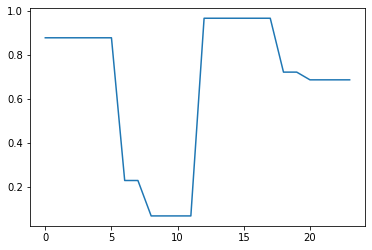

15.999999999999988


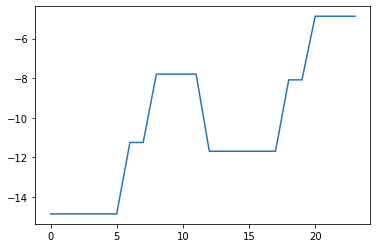

-178.63965857589278


In [165]:
plt.plot(one_particle_density)
plt.show()
print(np.sum(one_particle_density))

energy_values_meanfield=np.zeros((size_a+size_b))
for a in range(size_a+size_b):
    energy_values_meanfield[a]=SPS.energies[a]
    for b in range(size_a+size_b):
        if (a,b,a,b) in twobody_matrix.keys():
            energy_values_meanfield[a]+=twobody_matrix[(a,b,a,b)]*one_particle_density[b]/2

plt.plot(energy_values_meanfield)
plt.show()
        
print(np.sum(energy_values_meanfield*one_particle_density))


In [166]:
MeanFieldHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
print('size=',size_a+size_b,size_b)
MeanFieldHamiltonian.get_external_potential(external_potential=energy_values_meanfield)
#MeanFieldHamiltonian.twobody_operator=scipy.sparse.load_npz(f'data/nuclear_twobody_matrix/usdb_{nparticles_a-2}_{nparticles_b-2}.npz')
MeanFieldHamiltonian.get_hamiltonian()

egs,psi0=MeanFieldHamiltonian.get_spectrum(n_states=1)

print(egs)
print('total_m=',SPS.compute_m_exp_value(psi=psi0,basis=MeanFieldHamiltonian.basis)) 

size= 24 12
[-185.31551383]
total_m= [1.4012557e-45]


In [167]:
print(energy_values_meanfield)

[-14.87012213 -14.87012213 -14.87012213 -14.87012213 -14.87012213
 -14.87012213 -11.25356287 -11.25356287  -7.79600063  -7.79600063
  -7.79600063  -7.79600063 -11.69847079 -11.69847079 -11.69847079
 -11.69847079 -11.69847079 -11.69847079  -8.08563548  -8.08563548
  -4.86634268  -4.86634268  -4.86634268  -4.86634268]


In [168]:
print(MeanFieldHamiltonian.hamiltonian)
print(MeanFieldHamiltonian.basis[0])

  (0, 0)	-185.31551383374617
  (1, 1)	-185.31551383374617
  (2, 2)	-182.09622103362238
  (3, 3)	-182.09622103362238
  (4, 4)	-178.8769282334986
  (5, 5)	-178.48338572577288
  (6, 6)	-178.48338572577285
  (7, 7)	-175.26409292564907
  (8, 8)	-178.48338572577285
  (9, 9)	-175.26409292564907
  (10, 10)	-171.65125761779953
  (11, 11)	-178.48338572577285
  (12, 12)	-171.65125761779956
  (13, 13)	-171.6512576177996
  (14, 14)	-174.8668264733636
  (15, 15)	-174.8668264733636
  (16, 16)	-171.64753367323982
  (17, 17)	-168.03469836539028
  (18, 18)	-181.6989545813369
  (19, 19)	-178.4796617812131
  (20, 20)	-174.8668264733636
  (21, 21)	-174.8668264733636
  (22, 22)	-171.64753367323982
  (23, 23)	-168.03469836539028
  (24, 24)	-174.8668264733636
  :	:
  (7537, 7537)	-146.57034049961254
  (7538, 7538)	-143.35104769948876
  (7539, 7539)	-146.57034049961254
  (7540, 7540)	-143.35104769948876
  (7541, 7541)	-146.57034049961254
  (7542, 7542)	-139.73821239163925
  (7543, 7543)	-139.73821239163925
  (

#### Effective H_rr

In [169]:
from itertools import combinations
# you have to conserve the m valueeeee
def find_lowest_energy_subset(energy_values, m_values, sorted_indices):
    for size in range(2, len(sorted_indices) + 1, 2):  # Only even sizes (to make sum=0 possible)
        for subset in combinations(sorted_indices, size):  # Iterate over all subsets
            if np.sum(m_values[list(subset)]) == 0:  # Check if sum(m) == 0
                return np.array(subset)  # Return the first valid subset
    return np.array([])  # Return empty if no subset found

m_values=np.array([-5/2,-3/2,-1/2,1/2,3/2,5/2,-1/2,1/2,-3/2,-1/2,1/2,3/2,-5/2,-3/2,-1/2,1/2,3/2,5/2,-1/2,1/2,-3/2,-1/2,1/2,3/2])


mean_field_hamiltonian_rr=lil_matrix((rest_basis_ne20.shape[0],rest_basis_ne20.shape[0]))
basis_restricted=np.zeros_like(rest_basis_ne20)
elements=[]

for i,basis in enumerate(rest_basis_ne20):
    
    a,b,c,d=np.nonzero(basis)[0]


    comb_neutrons=combinations(QPC.couples[:size_a//2],(nparticles_a-2)//2)
    comb_protons=combinations(QPC.couples[size_a//2:],(nparticles_b-2)//2)
    
    
    min=0
    for set_neutron_couples in comb_neutrons:
        
        neutron_sets=[]
        for couple in set_neutron_couples:

            x,y=couple
            neutron_sets.append(x)
            neutron_sets.append(y)
        
        if a in neutron_sets or b in neutron_sets:
            continue

        for set_proton_couples in comb_protons:
            
            
            
            proton_sets=[]
            for couple in set_proton_couples:
                x,y=couple
                proton_sets.append(x)
                proton_sets.append(y)

            if c in proton_sets or d in proton_sets:
                continue
            

               

            
            if np.sum(m_values[[(proton_sets)]])+np.sum(m_values[[a,b,c,d]])+np.sum(m_values[[(neutron_sets)]])==0. :
                e_neutron=np.sum(energy_values_meanfield[[neutron_sets]])
                e_proton=np.sum(energy_values_meanfield[[proton_sets]])
                
                e_total=e_neutron+e_proton
                if e_total < min:
                    new_base=np.zeros((size_a+size_b))
                    min=e_total
                    if len(proton_sets)!=0:
                        new_base[[proton_sets]]=1
                    if len(neutron_sets)!=0:
                        new_base[[neutron_sets]]=1
                    new_base[[a,b,c,d]]=1
            else:
                continue
                    
    if min!=0:
        basis_restricted[i]=(new_base)

    

    

    energy_included=np.sum(energy_values_meanfield[[a,b]])+np.sum(energy_values_meanfield[[c,d]]) 
    energy_excluded= min

    if min!=0.:
        mean_field_hamiltonian_rr[i,i]=energy_excluded+energy_included



# dressed_qr_hamiltonian=lil_matrix((hamiltonian_ne20_qq.shape[0],rest_basis_ne20.shape[0]))
# qr_correction_dictionary=qr_correction.tocoo()
# for q,r,value in zip(qr_correction_dictionary.row,qr_correction_dictionary.col,qr_correction_dictionary.data):
#     basis=rest_basis_ne20[r]
#     i,j,k,l=np.nonzero(basis)[0]
#     min_values_sorted=np.sort(np.setdiff1d(energy_values_meanfield,[i,j,k,l]))
#     energy_excluded= np.sum(min_values_sorted[:4])
#     dressed_qr_hamiltonian[q,r]=qr_correction[q,r]+energy_excluded

# dressed_rq_hamiltonian=lil_matrix((rest_basis_ne20.shape[0],hamiltonian_ne20_qq.shape[0]))
# rq_correction_dictionary=rq_correction.tocoo()
# for r,q,value in zip(rq_correction_dictionary.row,rq_correction_dictionary.col,rq_correction_dictionary.data):
#     basis=rest_basis_ne20[r]
#     i,j,k,l=np.nonzero(basis)[0]
#     min_values_sorted=np.sort(np.setdiff1d(energy_values_meanfield,[i,j,k,l]))
#     energy_excluded= np.sum(min_values_sorted[:4])
#     dressed_rq_hamiltonian[r,q]=rq_correction[r,q]+energy_excluded    
    




/tmp/ipykernel_577035/1729250186.py:56: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if np.sum(m_values[[(proton_sets)]])+np.sum(m_values[[a,b,c,d]])+np.sum(m_values[[(neutron_sets)]])==0. :
/tmp/ipykernel_577035/1729250186.py:57: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  e_neutron=np.sum(energy_values_meanfield[[neutron_sets]])
/tmp/ipykernel_577035/1729250186.py:58: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpret

We need to correct the H_rq and H_qr

In [170]:
print(mean_field_hamiltonian_rr)

  (0, 0)	-164.41813911298098
  (1, 1)	-171.2502672209543
  (2, 2)	-164.41813911298098
  (3, 3)	-171.25026722095427
  (4, 4)	-168.0309744208305
  (5, 5)	-171.25026722095424
  (6, 6)	-164.41813911298098
  (7, 7)	-164.41813911298095
  (8, 8)	-171.25026722095424
  (9, 9)	-168.0309744208305
  (10, 10)	-171.25026722095427
  (11, 11)	-168.0309744208305
  (12, 12)	-171.25026722095424
  (13, 13)	-174.8631025288038
  (14, 14)	-178.08239532892756
  (15, 15)	-164.418139112981
  (16, 16)	-164.41813911298098
  (17, 17)	-171.25026722095427
  (18, 18)	-168.0309744208305
  (19, 19)	-171.25026722095427
  (20, 20)	-168.0309744208305
  (21, 21)	-171.2502672209543
  (22, 22)	-171.2502672209543
  (23, 23)	-174.86310252880384
  (24, 24)	-174.8631025288038
  (25, 25)	-178.0823953289276
  (26, 26)	-178.48338572577285
  (27, 27)	-175.26409292564904
  (28, 28)	-178.48338572577282
  (29, 29)	-175.26409292564904
  (30, 30)	-178.48338572577282
  (31, 31)	-178.48338572577285
  (32, 32)	-182.09622103362236
  (33, 33)

In [25]:
QPC=QuasiParticlesConverterOnlynnpp()

QPC.initialize_shell(state_encoding=SPS.state_encoding)


#just for the basis
QPC.get_the_basis_matrix_transformation(basis=NSMHamiltonian.basis)



In [172]:
#print(mean_field_hamiltonian_rr)


converted_quasiparticle_basis=np.zeros((QPC.quasiparticle_basis.shape[0],2*QPC.quasiparticle_basis.shape[1]))
for i,b in enumerate(QPC.quasiparticle_basis):
    index=np.nonzero(b)[0]
    new_base=np.zeros(2*QPC.quasiparticle_basis.shape[1])
    for idxs in index:
        new_base[QPC.couples[idxs]]=1
    converted_quasiparticle_basis[i]=new_base


In [173]:
dictionary_qr_correction=qr_correction.tocoo()
dictionary_qr_correction = {(row, col): value for row, col, value in zip(dictionary_qr_correction.row, dictionary_qr_correction.col, dictionary_qr_correction.data)}
print(QPC.couples)
effective_qr=lil_matrix((qr_correction.shape[0],qr_correction.shape[1]))
print(qr_correction.shape)
counter={}
for b in converted_quasiparticle_basis:
    counter[tuple(b)]=0.
print(counter)

for key,value in dictionary_qr_correction.items():
    a,i=key

        #print('keys=',key)
        
    x,y,z,w=np.nonzero(rest_basis_ne20[i])[0]
    new_item=basis_restricted[i].copy()

    new_item[[x,y,z,w]]=0.

    
    quasiparticle_indices=np.nonzero(quasiparticle_basis_ne20[a])[0]

    # for index in quasiparticle_indices:
    #     #print('couples=',QPC.couples[index])
    #     new_item[QPC.couples[index]]+=1
    #     print(np.sum(new_item),np.nonzero(new_item)[0],'with couple',QPC.couples[index])
    # # print('new indices=',new_item,'\n')
    # # print('sum=',np.sum(new_item))
    # if tuple(new_item) in counter.keys():
    #     # print('MARIO')
    #     # print(np.nonzero(new_item)[0],'\n')
        
    #     print(converted_quasiparticle_basis[a],'\n')
    #     print(basis_restricted[i],'\n')
    #     #if counter[tuple(new_item)]<=1:
    #     effective_qr[a,i]=value
    #     counter[tuple(new_item)]+=1
    # #print(new_item,converted_quasiparticle_basis[a])
    # else:
    #     print(key,'is not accepted \n')
            
    effective_qr[a,i]=value


# dictionary_rq_correction=rq_correction.tocoo()
# dictionary_rq_correction = {(row, col): value for row, col, value in zip(dictionary_rq_correction.row, dictionary_rq_correction.col, dictionary_rq_correction.data)}
# print(QPC.couples)
# effective_rq=lil_matrix((rq_correction.shape[0],rq_correction.shape[1]))
# for key,value in dictionary_rq_correction.items():
#     i,a=key
#     x,y,z,w=np.nonzero(rest_basis_ne20[i])[0]
#     new_item=basis_restricted[i].copy()
#     new_item[[x,y,z,w]]=0.
    
#     quasiparticle_indices=np.nonzero(quasiparticle_basis_ne20[a])[0]
#     for index in quasiparticle_indices:

#         new_item[QPC.couples[index]]+=1
#     if new_item in converted_quasiparticle_basis:
#         # print('MARIO')
#         # print(np.nonzero(new_item)[0],'\n')
#         effective_rq[i,a]=value
#     #print(new_item,converted_quasiparticle_basis[a])
#     else:
#         print(key,'is not accepted \n')  

    

[[0, 5], [1, 4], [2, 3], [6, 7], [8, 11], [9, 10], [12, 17], [13, 16], [14, 15], [18, 19], [20, 23], [21, 22]]
(36, 604)
{(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0): 0.0, (1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0): 0.0, (1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0): 0.0, (1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0): 0.0, (1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0): 0.0, (1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0): 0.0, (1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 

In [174]:
print(counter)
print(np.sum(list(counter.values())))

{(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0): 0.0, (1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0): 0.0, (1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0): 0.0, (1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0): 0.0, (1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0): 0.0, (1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0): 0.0, (1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0): 0.0, (1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0,

In [175]:
count_connections=0
for a in range(qr_correction.shape[0]):
    for i in range(qr_correction.shape[1]):
        if a==1 and qr_correction[a,i]!=0.:
            count_connections+=1

In [176]:
print(count_connections)
print(hamiltonian_qr)
print(hamiltonian_qr.shape)

for i in range(7):
    print(QPC.quasiparticle_basis[0])
    print(QPC.quasiparticle_basis[i],'\n')

60
  (0, 0)	-1.1102230246251565e-16
  (0, 1)	-1.27675647831893e-15
  (0, 2)	-1.8318679906315083e-15
  (0, 3)	-0.7108614512386662
  (0, 4)	0.977133826556014
  (0, 5)	1.609823385706477e-15
  (0, 6)	4.718447854656915e-16
  (0, 7)	0.5298448425179364
  (0, 8)	-0.7283125530979124
  (0, 9)	0.23695381707955535
  (0, 10)	0.410416050229172
  (0, 11)	-0.6514225510373428
  (0, 12)	-0.3869439629664616
  (0, 13)	-0.3869439629664616
  (0, 19)	4.85722573273506e-16
  (0, 20)	-0.3746568811211513
  (0, 21)	-0.6489247535071269
  (0, 22)	1.0299894902376425
  (0, 23)	0.09673599074161547
  (0, 24)	0.09673599074161547
  (0, 26)	0.410416050229172
  (0, 27)	0.23695381707955537
  (0, 28)	-0.6514225510373428
  (0, 38)	-0.7108614512386662
  (0, 39)	0.977133826556014
  :	:
  (399, 93270)	0.977133826556014
  (399, 93271)	0.7108614512386662
  (399, 93281)	-0.6514225510373428
  (399, 93282)	-0.23695381707955537
  (399, 93283)	-0.410416050229172
  (399, 93285)	-0.09673599074161547
  (399, 93286)	-0.09673599074161547
  

In [177]:
print(qr_correction)

  (0, 0)	-0.45876507936507965
  (0, 1)	1.096283198521862
  (0, 2)	0.11816984126984101
  (0, 4)	-0.027423351397426327
  (0, 5)	-0.44278468996383347
  (0, 6)	-0.2881301587301583
  (0, 11)	0.4808606694347589
  (0, 12)	0.6322793396075583
  (0, 15)	0.23103492063492015
  (0, 22)	-0.8929983991364584
  (0, 26)	0.20328479938540367
  (0, 27)	-0.5082840208321852
  (0, 28)	0.1894946496437248
  (0, 29)	0.5082840208321852
  (0, 30)	0.18949464964372487
  (0, 31)	0.20328479938540364
  (0, 32)	0.483679953708077
  (0, 33)	0.483679953708077
  (0, 34)	0.027423351397426327
  (0, 36)	-0.2245657281313674
  (0, 37)	0.23371242231056472
  (0, 38)	-0.4808606694347589
  (0, 43)	0.6762161618582865
  (0, 44)	0.2499675313975125
  (0, 47)	1.0962831985218615
  :	:
  (35, 534)	-0.11179270703329697
  (35, 536)	0.3837438166376979
  (35, 538)	-0.32893247559339583
  (35, 552)	-0.4744024744405058
  (35, 554)	0.21613933262539406
  (35, 556)	-0.64662
  (35, 561)	0.5061955498269921
  (35, 563)	-0.2414661373377319
  (35, 566)	-

In [178]:
print(effective_qr.shape,QPC.quasiparticle_basis.shape[0])
for i in range(quasiparticle_basis_ne20.shape[0]):
    for j in range(quasiparticle_basis_ne20.shape[0]):
        print((effective_qr @ effective_qr.T)[i,j],i,j)

(36, 604) 120
22.250253882563612 0 0
-5.025788110465884 0 1
3.8834760421294137 0 2
5.505936580591535 0 3
14.059724361739434 0 4
-4.093170625774788 0 5
-5.025788110465886 0 6
0.527685065195263 0 7
0.0 0 8
0.0 0 9
-3.9985659844432035 0 10
0.0 0 11
3.8834760421294128 0 12
0.0 0 13
0.19396619951121147 0 14
0.46395804722222245 0 15
0.0 0 16
-1.1916708899218762 0 17
5.505936580591536 0 18
0.0 0 19
0.46395804722222245 0 20
1.015396127619047 0 21
0.0 0 22
-0.23421052619047628 0 23
14.05972436173943 0 24
-3.998565984443199 0 25
0.0 0 26
0.0 0 27
6.075247869208319 0 28
0.0 0 29
-4.093170625774788 0 30
0.0 0 31
-1.1916708899218755 0 32
-0.23421052619047628 0 33
0.0 0 34
0.3830202240456472 0 35
-5.025788110465884 1 0
26.041858506780386 1 1
-1.3538070115793654 1 2
-1.2545371078034688 1 3
-7.754701850430439 1 4
-0.05724458350705776 1 5
8.898971797188217 1 6
-1.239488045165389 1 7
0.010431571882086333 1 8
0.7399263469095827 1 9
0.0 1 10
-0.023355460225575105 1 11
0.0 1 12
0.7131681897491131 1 13
-0.1

In [ ]:
# for i in range(quasiparticle_basis_ne20.shape[0]):
#     for j in range(quasiparticle_basis_ne20.shape[0]):
#         print((qr_correction @ rq_correction)[i,j],i,j)
print(hamiltonian_qr.shape)
for i in range(QPC.quasiparticle_basis.shape[0]):
    for j in range(QPC.quasiparticle_basis.shape[0]):
        print((hamiltonian_qr @ hamiltonian_rq)[i,j],i,j)

(400, 93310)
62.06484601000005 0 0
4.82602374704741 0 1
4.61050982079444 0 2
-6.388547386431676 0 3
-4.826023747047411 0 4
-4.826058422308022 0 5
5.270567813717329 0 6
-1.122942228571428 0 7
0.18715703809523793 0 8
2.758283709999996 0 9
4.826023747047409 0 10
6.881531373496555 0 11
-4.6589844164500125 0 12
0.5614711142857144 0 13
-0.748628152380952 0 14
-1.06087835 0 15
-0.28073555714285714 0 16
1.0293637095238095 0 17
2.121756699999999 0 18
0.0 0 19
4.826023747047408 0 20
0.9664389801904756 0 21
0.00014268342857142827 0 22


-0.14978376076190475 0 23
-0.13055239314285727 0 24
-0.2846362766542761 0 25
0.08048905391715225 0 26
0.0 0 27
0.0 0 28
0.0 0 29
0.0 0 30
0.1403677785714287 0 31
0.0 0 32
0.0 0 33
0.0 0 34
0.0 0 35
0.0 0 36
0.0 0 37
0.0 0 38
0.0 0 39
4.610509820794438 0 40
0.00014268342857142827 0 41
0.5518312629848141 0 42
-0.07222982628231656 0 43
-0.27708849706000926 0 44
0.0 0 45
1.9490531071304897 0 46
0.0 0 47
0.0 0 48
0.0 0 49
0.1403677785714287 0 50
0.7725070222222236 0 51
-1.6285972912312883 0 52
0.0 0 53
0.0 0 54
0.0 0 55
0.0 0 56
0.0 0 57
0.0 0 58
0.0 0 59
-6.388547386431673 0 60
-0.14978376076190475 0 61
-0.07222982628231657 0 62
5.571201820323564 0 63
0.08803683351141911 0 64
0.12326083999422874 0 65
-0.898127069780044 0 66
0.0 0 67
0.0 0 68
0.0 0 69
0.0 0 70
-0.06060241710204644 0 71
0.0 0 72
0.0 0 73
0.0 0 74
0.0 0 75
0.0 0 76
0.0 0 77
0.0 0 78
0.0 0 79
-4.82602374704741 0 80
-0.1305523931428572 0 81
-0.27708849706000926 0 82
0.08803683351141912 0 83
0.8848437344761901 0 84
0.0 0 85
-0.0

In [180]:
print(hamiltonian_qr)
count_connections=0
for a in range(hamiltonian_qr.shape[0]):
    for i in range(hamiltonian_qr.shape[1]):
        if a==6 and hamiltonian_qr[a,i]!=0.:
            count_connections+=1
            
# count_connections=0
# for i in range(hamiltonian_qr.shape[1]):
#     if hamiltonian_qr[0,i]!=0. and hamiltonian_qr[1,i]!=0.:
#         count_connections+=1

# count_connections=0
# for i in range(qr_correction.shape[1]):
#     if qr_correction[0,i]!=0. and qr_correction[1,i]!=0.:
#         count_connections+=1



  (0, 0)	-1.1102230246251565e-16
  (0, 1)	-1.27675647831893e-15
  (0, 2)	-1.8318679906315083e-15
  (0, 3)	-0.7108614512386662
  (0, 4)	0.977133826556014
  (0, 5)	1.609823385706477e-15
  (0, 6)	4.718447854656915e-16
  (0, 7)	0.5298448425179364
  (0, 8)	-0.7283125530979124
  (0, 9)	0.23695381707955535
  (0, 10)	0.410416050229172
  (0, 11)	-0.6514225510373428
  (0, 12)	-0.3869439629664616
  (0, 13)	-0.3869439629664616
  (0, 19)	4.85722573273506e-16
  (0, 20)	-0.3746568811211513
  (0, 21)	-0.6489247535071269
  (0, 22)	1.0299894902376425
  (0, 23)	0.09673599074161547
  (0, 24)	0.09673599074161547
  (0, 26)	0.410416050229172
  (0, 27)	0.23695381707955537
  (0, 28)	-0.6514225510373428
  (0, 38)	-0.7108614512386662
  (0, 39)	0.977133826556014
  :	:
  (399, 93270)	0.977133826556014
  (399, 93271)	0.7108614512386662
  (399, 93281)	-0.6514225510373428
  (399, 93282)	-0.23695381707955537
  (399, 93283)	-0.410416050229172
  (399, 93285)	-0.09673599074161547
  (399, 93286)	-0.09673599074161547
  (39

KeyboardInterrupt: 

In [ ]:
print(count_connections)


146


In [ ]:
print(mean_field_hamiltonian_rr)

  (0, 0)	-69.22227151045246
  (1, 1)	-62.713736640738254
  (2, 2)	-69.22227151045249
  (3, 3)	-62.71373664073829
  (4, 4)	-66.9549812277124
  (5, 5)	-62.71373664073822
  (6, 6)	-69.22227151045249
  (7, 7)	-69.22227151045252
  (8, 8)	-62.713736640738276
  (9, 9)	-66.95498122771242
  (10, 10)	-62.71373664073825
  (11, 11)	-66.9549812277124
  (12, 12)	-62.71373664073822
  (13, 13)	-60.446446357998184
  (14, 14)	-56.20520177102401
  (15, 15)	-69.22227151045246
  (16, 16)	-69.2222715104525
  (17, 17)	-62.71373664073826
  (18, 18)	-66.9549812277124
  (19, 19)	-62.71373664073822
  (20, 20)	-66.95498122771241
  (21, 21)	-62.71373664073823
  (22, 22)	-62.71373664073825
  (23, 23)	-60.44644635799817
  (24, 24)	-60.44644635799812
  (25, 25)	-56.205201771023994
  (26, 26)	-62.71373664073833
  (27, 27)	-66.95498122771245
  (28, 28)	-62.713736640738276
  (29, 29)	-66.95498122771247
  (30, 30)	-62.713736640738276
  (31, 31)	-62.71373664073834
  (32, 32)	-60.446446357998184
  (33, 33)	-60.446446357998

I build up new approximations with this new h_rr

In [181]:
approximations=[]
off_diagonal_hamiltonians_rr=[]
nsteps_iteration=30
single_term = effective_qr.T  # Start with initial term

for i in trange(nsteps_iteration):
    if i > 0:
        single_term = mean_field_hamiltonian_rr @ single_term  # Efficient update
    approximator=effective_qr @ single_term
    if i==0:
            print(approximator[:5,:5])
    for r in range(approximator.shape[0]):
        approximator[r,r]=approximator[r,r]

        
    approximations.append(approximator)  # Store result

two_body_corrections=[]
for operator in approximations:
    twobody_term={}
    for i,b in enumerate(quasiparticle_basis_ne20):
        for j,d in enumerate(quasiparticle_basis_ne20):

            idx_a,idx_b=np.nonzero(b)[0]
            idx_c,idx_d=np.nonzero(d)[0]
            if idx_a < len(QPC.couples)//2 and idx_b >= len(QPC.couples)//2 and idx_d >= len(QPC.couples)//2 and idx_c < len(QPC.couples)//2:  
                twobody_term[(idx_a,idx_b,idx_c,idx_d)]=operator[i,j]#-external_potential_qq[i,j]
            else:
                print(b)
                print(d)
                print(idx_a,idx_b,idx_c,idx_d)
                print('wwwwwaaat?')
    two_body_corrections.append(twobody_term)



100%|██████████| 30/30 [00:00<00:00, 372.98it/s]


  (0, 3)	5.505936580591535
  (0, 2)	3.8834760421294137
  (0, 4)	14.059724361739434
  (0, 1)	-5.025788110465884
  (0, 0)	22.250253882563612
  (1, 3)	-1.2545371078034688
  (1, 2)	-1.3538070115793654
  (1, 4)	-7.754701850430439
  (1, 1)	26.041858506780386
  (1, 0)	-5.025788110465884
  (2, 3)	1.1252863425050987
  (2, 4)	4.060900938806812
  (2, 1)	-1.3538070115793654
  (2, 2)	23.37550635347493
  (2, 0)	3.8834760421294137
  (3, 2)	1.1252863425050987
  (3, 4)	4.6460646529147205
  (3, 1)	-1.2545371078034688
  (3, 3)	28.470850538208335
  (3, 0)	5.505936580591535
  (4, 3)	4.6460646529147205
  (4, 2)	4.060900938806812
  (4, 1)	-7.754701850430439
  (4, 4)	37.7923374863108
  (4, 0)	14.059724361739434


Build the corresponding $H_{qq}$ using qubits

check the $H_{QQ}$

In [36]:
hamiltonian_qq=QPC.particles2quasiparticles @ NSMHamiltonian.hamiltonian @ QPC.particles2quasiparticles.T
hamiltonian_rr=QPC.particles2restofstates @ NSMHamiltonian.hamiltonian @ QPC.particles2restofstates.T

hamiltonian_rq=QPC.particles2restofstates @ NSMHamiltonian.hamiltonian @ QPC.particles2quasiparticles.T
hamiltonian_qr=QPC.particles2quasiparticles @ NSMHamiltonian.hamiltonian @ QPC.particles2restofstates.T

value,_=eigsh(hamiltonian_qq,k=1)

print(value[0])
print((value[0]-egs)/egs)

print('norm ham_rr=',scipy.sparse.linalg.norm(hamiltonian_rr))
value,_=eigsh(hamiltonian_rr,k=1)
print(value[0])

    

print(hamiltonian_rr[:5,:5])

ValueError: dimension mismatch

In [183]:
print((hamiltonian_qr @ hamiltonian_qr.T)[0:5,0:5])
print((hamiltonian_qr @ hamiltonian_rq)[80,200])


  (0, 4)	7.594513776794784
  (0, 3)	-9.383992537384197
  (0, 2)	-5.959860904882025
  (0, 1)	-1.005951070259839
  (0, 0)	43.85456546808992
  (1, 4)	-6.401527936401845
  (1, 3)	4.612049175812435
  (1, 2)	5.959860904882026
  (1, 1)	43.8545654680899
  (1, 0)	-1.005951070259839
  (2, 4)	-4.574256756695191
  (2, 3)	4.574256756695191
  (2, 2)	23.071936367500005
  (2, 1)	5.959860904882026
  (2, 0)	-5.959860904882025
  (3, 4)	-6.527988652241625
  (3, 3)	76.33266758399814
  (3, 2)	4.574256756695191
  (3, 1)	4.612049175812435
  (3, 0)	-9.383992537384197
  (4, 4)	75.29997063864177
  (4, 3)	-6.527988652241625
  (4, 2)	-4.574256756695191
  (4, 1)	-6.401527936401845
  (4, 0)	7.594513776794784


IndexError: column index (200) out of range

In [184]:

delta_hamiltonian=0.
QubitBasis=HardcoreBosonsBasis(basis=QPC.quasiparticle_basis)
count=0    
for keys,values in two_body_corrections[0].items():
            idx_a,idx_b,idx_c,idx_d=keys
            neutron_denominator=(nparticles_a//2 -1)
            proton_denominator=(nparticles_b//2 -1)
            
            if neutron_denominator==0:
                neutron_denominator=1
            if proton_denominator==0:
                proton_denominator=1
            
            if idx_a==idx_c and idx_b!=idx_d:
                correction_term=values*QubitBasis.adag_adag_a_a_matrix(idx_a,idx_b,idx_c,idx_d)#/neutron_denominator
            elif (idx_a==idx_c and idx_b==idx_d) or (idx_a==idx_d and idx_b==idx_c):

                correction_term=values*QubitBasis.adag_adag_a_a_matrix(idx_a,idx_b,idx_c,idx_d)/((proton_denominator*neutron_denominator))

            elif idx_b==idx_d and idx_a!=idx_c:

                correction_term=values*QubitBasis.adag_adag_a_a_matrix(idx_a,idx_b,idx_c,idx_d)#/proton_denominator

                if correction_term[80,200]!=0.:
                   print(correction_term[80,200])
                   count+=1
                # if correction_term[0,0]!=0.:
                #     count+=1
            else:
                correction_term=values*QubitBasis.adag_adag_a_a_matrix(idx_a,idx_b,idx_c,idx_d)
            delta_hamiltonian+=correction_term/(e*(e)**(j))

            delta_hamiltonian+=correction_term


IndexError: column index (200) out of bounds

In [153]:
print(count)

3


In [160]:

print(np.max(delta_hamiltonian))

  (0, 0)	59.8748428228188
  (0, 1)	8.482258602871534
  (0, 2)	9.672381300373313
  (0, 3)	-19.91599015112601
  (0, 4)	-7.012576567033028
  (0, 5)	-16.433687965502777
  (0, 6)	14.025471526090541
  (0, 10)	7.014501789949808
  (0, 11)	17.95095986723083
  (0, 12)	-8.774584591069715
  (0, 20)	8.482258602871534
  (0, 21)	0.9664389801904756
  (0, 22)	0.00014268342857142827
  (0, 23)	-0.14978376076190475
  (0, 24)	-0.13055239314285727
  (0, 25)	-0.2846362766542761
  (0, 26)	0.08048905391715225
  (0, 31)	0.1403677785714287
  (0, 40)	9.672381300373312
  (0, 41)	0.00014268342857142827
  (0, 42)	0.5518312629848141
  (0, 43)	-0.07222982628231656
  (0, 44)	-0.27708849706000926
  (0, 46)	1.9490531071304897
  (0, 50)	0.1403677785714287
  (0, 51)	0.7725070222222236
  (0, 52)	-1.6285972912312883
  (0, 60)	-19.91599015112601
  (0, 61)	-0.14978376076190475
  (0, 62)	-0.07222982628231657
  (0, 63)	5.571201820323564
  (0, 64)	0.08803683351141911
  (0, 65)	0.12326083999422874
  (0, 66)	-0.898127069780044
  (0

#### Effective 2 body Hamiltonian

In [282]:
QPC=QuasiParticlesConverterOnlynnpp()

QPC.initialize_shell(state_encoding=SPS.state_encoding)


#just for the basis
QPC.get_the_basis_matrix_transformation(basis=NSMHamiltonian.basis)

In [283]:
hamiltonian_qq=QPC.particles2quasiparticles @ NSMHamiltonian.hamiltonian @ QPC.particles2quasiparticles.T
hamiltonian_rr=QPC.particles2restofstates @ NSMHamiltonian.hamiltonian @ QPC.particles2restofstates.T
hamiltonian_qr=QPC.particles2quasiparticles @ NSMHamiltonian.hamiltonian @ QPC.particles2restofstates.T
hamiltonian_rq=QPC.particles2restofstates @ NSMHamiltonian.hamiltonian @ QPC.particles2quasiparticles.T
external_potential_qq=QPC.particles2quasiparticles @ NSMHamiltonian.external_potential @ QPC.particles2quasiparticles.T

twobody_qq=QPC.particles2quasiparticles @ NSMHamiltonian.twobody_operator @ QPC.particles2quasiparticles.T
twobody_qr=QPC.particles2quasiparticles @ NSMHamiltonian.twobody_operator @ QPC.particles2restofstates.T
twobody_rq=QPC.particles2restofstates @ NSMHamiltonian.twobody_operator @ QPC.particles2quasiparticles.T
twobody_rr=QPC.particles2restofstates @ NSMHamiltonian.twobody_operator @ QPC.particles2restofstates.T

In [284]:

    
tot_hamiltonian=hamiltonian_qq
values,psi=eigsh(hamiltonian_qq,k=1)
e=values[0]
approximations=[]
nsteps_iteration=40
single_term = hamiltonian_rq  # Start with initial term
for i in trange(nsteps_iteration):
    if i > 0:
        single_term =hamiltonian_rr @ single_term  # Efficient update
    update=(hamiltonian_qr @ single_term)

    approximations.append(update)  # Store result
    
history_errors_exact=[]
for i in trange(nsteps_iteration):
    
    tot_hamiltonian=hamiltonian_qq
    delta_hamiltonian_exact=0.
    for j in range(i):
        delta_hamiltonian_exact=delta_hamiltonian_exact+approximations[j]/e**(j+1)
    values,psifinal=eigsh(hamiltonian_qq+delta_hamiltonian_exact,k=1)
    tot_hamiltonian=hamiltonian_qq+delta_hamiltonian_exact
    e=values[0]
    print(e)
    print(np.abs((e-egs[0])/egs[0]),'index=',i)
    history_errors_exact.append(np.abs((e-egs[0])/egs[0]))

 32%|███▎      | 13/40 [00:00<00:00, 119.92it/s]

-78.95747726463038
0.14893770480544652 index= 0
-80.68469572662976
0.1303204622149202 index= 1
-82.15997925843395
0.11441876129770456 index= 2
-83.40331868640942
0.10101712608927196 index= 3
-84.45507345042344
0.08968053259042484 index= 4
-85.3532380454168
0.07999944793373517 index= 5
-86.12743116097191
0.07165461989876824 index= 6
-86.79988336111518
0.06440643096607898 index= 7
-87.38751956876222
0.058072451754162834 index= 8
-87.90357764946661
0.05250999472243695 index= 9
-88.35867711239608
0.04760459491888897 index= 10
-88.76150542400984
0.043262612381854096 index= 11
-89.11927002668322
0.03940635994777371 index= 12
-89.4380100464096
0.035970743434222754 index= 13
-89.72282215380878
0.0329008271423186 index= 14
-89.97803132083595
0.03014999331416977 index= 15
-90.20732415639624
0.027678504942655897 index= 16
-90.41385538540608
0.025452358061071007 index= 17
-90.60033418551386
0.023442351141866342 index= 18
-90.76909489896089
0.021623322911727628 index= 19


 62%|██████▎   | 25/40 [00:00<00:00, 85.69it/s] 

-90.9221553586261
0.019973523670173566 index= 20
-91.06126523761361
0.018474094141814227 index= 21
-91.1879462952073
0.017108631675580497 index= 22
-91.30352598499312
0.015862827991436495 index= 23
-91.40916561368664
0.014724165663635845 index= 24
-91.50588399430049
0.013681663169326834 index= 25
-91.5945773820406
0.012725660004665315 index= 26
-91.67603631008305
0.0118476352163157 index= 27
-91.75095986611653
0.011040053518279901 index= 28
-91.81996780586218
0.010296234723389332 index= 29
-91.8836108974968
0.009610242243433317 index= 30
-91.9423797240995
0.008976788209855792 index= 31


100%|██████████| 40/40 [00:00<00:00, 67.45it/s]

-91.99671227774131
0.00839115161902088 index= 32
-92.04700039951958
0.007849108916742118 index= 33
-92.09359545785638
0.007346872793367268 index= 34
-92.1368130374574
0.006881041642699621 index= 35
-92.17693735293695
0.006448551988671261 index= 36
-92.2142244812641
0.006046643643639395 index= 37
-92.24890620035092
0.005672818333233444 index= 38
-92.28119154466799
0.0053248229287761115 index= 39


In [293]:
QubitBasis=HardcoreBosonsBasis(basis=QPC.quasiparticle_basis)

h_qq=0.
count=0.
for key,value in one_body.items():
    idx_a,idx_b=key

    h_qq+=value*QubitBasis.adag_a_matrix(idx_a,idx_b)

for key,value in twobody_nn.items():
    idx_a,idx_b,idx_c,idx_d=key

    h_qq+=value*QubitBasis.adag_adag_a_a_matrix(idx_a,idx_b,idx_c,idx_d)
    
for key,value in twobody_nnpp.items():
    idx_a,idx_b,idx_c,idx_d=key

    h_qq+=value*QubitBasis.adag_adag_a_a_matrix(idx_a,idx_b,idx_c,idx_d)

delta_hamiltonian=0.
for key,value in twobody_term_last_correction.items():
    idx_a,idx_b,idx_c,idx_d=key
    neutron_denominator=(nparticles_a//2 )
    proton_denominator=(nparticles_b//2 )
    
    if neutron_denominator==0:
        neutron_denominator=1
    if proton_denominator==0:
        proton_denominator=1

    if idx_a==idx_c and idx_b!=idx_d:

        correction_term=value*QubitBasis.adag_adag_a_a_matrix(idx_a,idx_b,idx_c,idx_d)#/((neutron_denominator))
        
    elif (idx_a==idx_c and idx_b==idx_d) or (idx_a==idx_d and idx_b==idx_c):

        correction_term=value*QubitBasis.adag_adag_a_a_matrix(idx_a,idx_b,idx_c,idx_d)#/((proton_denominator*neutron_denominator))
        #print('numbers=',idx_a,idx_b,idx_c,idx_d)
        #print(correction_term)
        if correction_term[0,0]!=0.:
            count+=1
    elif (idx_b==idx_d and idx_a!=idx_c) :
        #print('proton denominator=',idx_a,idx_b,idx_c,idx_d)
        correction_term=value*QubitBasis.adag_adag_a_a_matrix(idx_a,idx_b,idx_c,idx_d)#/((proton_denominator))


    else:

        correction_term=value*QubitBasis.adag_adag_a_a_matrix(idx_a,idx_b,idx_c,idx_d)#/((proton_denominator*neutron_denominator))
    delta_hamiltonian+=correction_term

delta_hamiltonian_nn=0.
for key,value in twobody_term_corrections_nn.items():
    idx_a,idx_b,idx_c,idx_d=key
    neutron_denominator=(nparticles_a//2 )
    proton_denominator=(nparticles_b//2 )
    if neutron_denominator==0:
        neutron_denominator=1
    if proton_denominator==0:
        proton_denominator=1
    if idx_a==idx_c and idx_b!=idx_d:
        correction_term=value*QubitBasis.adag_adag_a_a_matrix(idx_a,idx_b,idx_c,idx_d)   
    elif (idx_a==idx_c and idx_b==idx_d) or (idx_a==idx_d and idx_b==idx_c):
        correction_term=value*QubitBasis.adag_adag_a_a_matrix(idx_a,idx_b,idx_c,idx_d)
        #print('numbers=',idx_a,idx_b,idx_c,idx_d)
        #print(correction_term)
        if correction_term[0,0]!=0.:
            count+=1
    elif (idx_b==idx_d and idx_a!=idx_c) :
        #print('proton denominator=',idx_a,idx_b,idx_c,idx_d)
        correction_term=value*QubitBasis.adag_adag_a_a_matrix(idx_a,idx_b,idx_c,idx_d)
    else:
        correction_term=value*QubitBasis.adag_adag_a_a_matrix(idx_a,idx_b,idx_c,idx_d)
    delta_hamiltonian_nn+=correction_term
    
delta_hamiltonian_pp=0.
for key,value in twobody_term_corrections_pp.items():
    idx_a,idx_b,idx_c,idx_d=key
    neutron_denominator=(nparticles_a//2 )
    proton_denominator=(nparticles_b//2 )
    if neutron_denominator==0:
        neutron_denominator=1
    if proton_denominator==0:
        proton_denominator=1
    if idx_a==idx_c and idx_b!=idx_d:
        correction_term=value*QubitBasis.adag_adag_a_a_matrix(idx_a,idx_b,idx_c,idx_d)   
    elif (idx_a==idx_c and idx_b==idx_d) or (idx_a==idx_d and idx_b==idx_c):
        correction_term=value*QubitBasis.adag_adag_a_a_matrix(idx_a,idx_b,idx_c,idx_d)
        #print('numbers=',idx_a,idx_b,idx_c,idx_d)
        #print(correction_term)
        if correction_term[0,0]!=0.:
            count+=1
    elif (idx_b==idx_d and idx_a!=idx_c) :
        #print('proton denominator=',idx_a,idx_b,idx_c,idx_d)
        correction_term=value*QubitBasis.adag_adag_a_a_matrix(idx_a,idx_b,idx_c,idx_d)
    else:
        correction_term=value*QubitBasis.adag_adag_a_a_matrix(idx_a,idx_b,idx_c,idx_d)
    delta_hamiltonian_pp+=correction_term
    
h_quibit_tot=h_qq+2*delta_hamiltonian/(neutron_denominator*proton_denominator)+delta_hamiltonian_nn/(neutron_denominator*(neutron_denominator-1)/2)+delta_hamiltonian_pp/(proton_denominator*(proton_denominator-1)/2)

value,psiqubit=eigsh(h_quibit_tot,k=1)
print(value[0])



-90.98538012571588


In [294]:
print(delta_hamiltonian/(neutron_denominator)+delta_hamiltonian_nn/(neutron_denominator*(neutron_denominator-1)/2))

  (0, 0)	-4.23727715097434
  (0, 1)	0.5421934805280457
  (0, 2)	0.5679417249298244
  (0, 3)	0.5676740191157694
  (0, 4)	-0.5298895586439045
  (0, 5)	-0.3777410270830479
  (0, 6)	-0.6270740525793973
  (0, 7)	-0.747091739643945
  (0, 8)	0.273569756638724
  (0, 15)	0.6302059669416138
  (0, 16)	-0.09415899014495775
  (0, 17)	-0.13639262432244584
  (0, 18)	-0.08178310084845061
  (0, 19)	0.19484208947376944
  (0, 20)	-0.0037733117976487098
  (0, 21)	0.059795693024004004
  (0, 22)	0.08178232402603036
  (0, 23)	-0.040331850148025664
  (0, 30)	0.4625113761445553
  (0, 31)	-0.1363926243224458
  (0, 32)	-0.18013620188240212
  (0, 33)	-0.057991419826993525
  (0, 34)	0.10488017276187724
  (0, 35)	0.026144260237756307
  (0, 36)	0.11033835918375032
  :	:
  (224, 187)	0.05927512353922831
  (224, 188)	-0.03637485453049693
  (224, 190)	-0.0973125521988167
  (224, 191)	0.01942564423330108
  (224, 192)	-0.07518457230836537
  (224, 193)	0.038955893990347004
  (224, 194)	0.14379653989799562
  (224, 198)	0.0

In [295]:
print(delta_hamiltonian_exact)

  (0, 145)	-0.03577111614874761
  (0, 147)	-0.018255067796964657
  (0, 149)	0.01948771197987474
  (0, 175)	0.03221562136104004
  (0, 177)	0.01247148753484413
  (0, 179)	-0.015670684945693323
  (0, 160)	-0.04459056119514634
  (0, 162)	-0.022617940071283447
  (0, 164)	0.02282644926863172
  (0, 144)	-0.05976633659163958
  (0, 146)	0.04262136401516975
  (0, 174)	0.04262136401516975
  (0, 176)	-0.05855091224034862
  (0, 159)	-0.035771116148747624
  (0, 161)	0.03221562136104004
  (0, 148)	0.05666104079277881
  (0, 178)	-0.039853918453889144
  (0, 163)	0.03847023686863098
  (0, 220)	0.022826449268631695
  (0, 190)	-0.022617940071283447
  (0, 205)	0.03847023686863095
  (0, 219)	0.019487711979874745
  (0, 189)	-0.01825506779696467
  (0, 204)	0.056661040792778804
  (0, 221)	-0.015670684945693313
  :	:
  (224, 10)	0.009857275337399813
  (224, 7)	-0.010836191642334594
  (224, 4)	-0.009882614742089872
  (224, 13)	-0.006021511514769464
  (224, 12)	0.006025345271444973
  (224, 131)	0.0039770989473677

In [296]:
parameter=np.linspace(0,6,200)
error = np.average(np.abs(
    tot_hamiltonian.toarray()[None, :, :] -
     - h_qq.toarray()[None,:,:]-parameter[:, None, None] * delta_hamiltonian.toarray()[None, :, :]
),axis=(-1,-2))

# delta_eng=[]
# for i in range(parameter.shape[0]):
#     energy_exact,psi_exact=eigsh(tot_hamiltonian,k=1)
#     energy_exact=energy_exact[0]
#     psi_exact=psi_exact[:,0]
#     energy,psi=eigsh(h_qq+parameter[i]*delta_hamiltonian,k=1)
#     energy=energy[0]
#     psi=psi[:,0]
#     fidelity=psi[:].conjugate().dot(psi_exact[:])*np.conjugate(psi[:].conjugate().dot(psi_exact[:]))
#     print(energy,energy_exact)
#     delta_eng.append(np.abs(energy_exact-energy)/np.abs(energy_exact)+np.abs(1-fidelity))
    



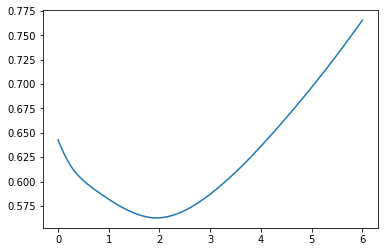

0.5627271075699422
1.92964824120603


In [297]:

plt.plot(parameter,error)
plt.show()

print(np.min(error))
print(parameter[np.argmin(error)])

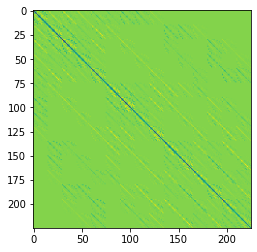

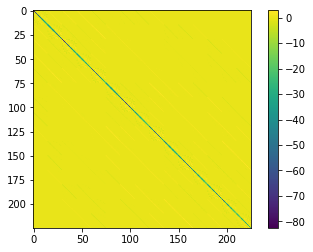

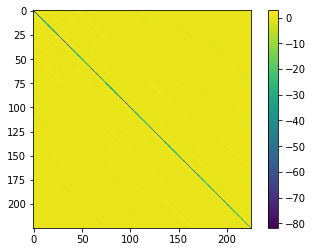

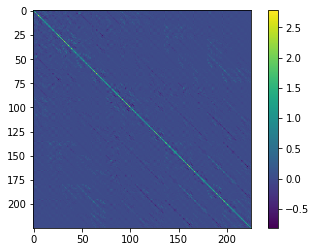

In [298]:
plt.imshow(delta_hamiltonian.todense())
plt.show()

plt.imshow(h_quibit_tot.todense())
plt.colorbar()
plt.show()

plt.imshow(tot_hamiltonian.todense())
plt.colorbar()
plt.show()

plt.imshow(tot_hamiltonian.todense()-h_quibit_tot.todense())
plt.colorbar()
plt.show()



In [299]:
count=0
for i in range(delta_hamiltonian.shape[0]):
    if delta_hamiltonian[22,i]!=0:
        print(delta_hamiltonian_exact[22,i])
        print(delta_hamiltonian[22,i],'\n')
        count+=1

print(count)

0.1857385585723851
0.16356464805206072 

-0.07700395695401963
-0.1197471121623421 

0.056654543111802604
0.12333198250327246 

0.12935678437698978
0.13818399727527408 

0.5193692071463163
0.9755033430221601 

-0.15356452407719576
-0.22299477351068764 

-0.2587672023220797
-0.7742460702975376 

-0.0869473788921353
-0.33806827388522276 

0.12211347027712176
0.49064028190219294 

-0.572945852425847
-1.330651433286929 

0.29365934017732775
0.6594620704584476 

-0.3218145421677063
-0.668991014786953 

-0.3093181743590019
-0.8062064871408965 

-2.931885731923415
-6.262811953338962 

0.2741032866770023
0.4485157194697664 

0.19730224770088303
0.6768888287392911 

0.2536589491218241
0.8149582599215947 

-0.10950506474370363
-0.5921423654394229 

-0.08668083996725898
-0.17130956494545474 

0.07778975385271564
0.06809555676936029 

-0.10216598474359474
-0.07554940748170257 

-0.05687988102034604
-0.15236673197628353 

-0.25612058688268236
-0.6196128238531415 

0.03117630650523537
0.0514360161711

In [300]:
print(psifinal[:,0].conjugate().dot(psiqubit[:,0])*np.conjugate(psifinal[:,0].conjugate().dot(psiqubit[:,0])))

0.9818660673425009


In [301]:
print((psiqubit[:,0].conjugate().dot(tot_hamiltonian.dot(psiqubit[:,0]))))

-91.9493644363609


Arbitrary order with a loop

In [295]:
from scipy.sparse import identity

QubitBasis=HardcoreBosonsBasis(basis=QPC.quasiparticle_basis)
external_potential_qq=QPC.particles2quasiparticles @ NSMHamiltonian.external_potential @ QPC.particles2quasiparticles.T
print(external_potential_qq.shape)

h_qq=0.

for key,value in one_body.items():
    idx_a,idx_b=key

    h_qq+=value*QubitBasis.adag_a_matrix(idx_a,idx_b)

for key,value in twobody_nn.items():
    idx_a,idx_b,idx_c,idx_d=key

    h_qq+=value*QubitBasis.adag_adag_a_a_matrix(idx_a,idx_b,idx_c,idx_d)
    
for key,value in twobody_nnpp.items():
    idx_a,idx_b,idx_c,idx_d=key

    h_qq+=value*QubitBasis.adag_adag_a_a_matrix(idx_a,idx_b,idx_c,idx_d)
    
    
for r,correction in enumerate(two_body_corrections):

    delta_hamiltonian=0.    
    for j in trange(r):
        for keys,values in two_body_corrections[j].items():
            idx_a,idx_b,idx_c,idx_d=keys
            
            neutron_denominator=(nparticles_a//2 -1)
            proton_denominator=(nparticles_b//2 -1)
            
            if neutron_denominator==0:
                neutron_denominator=1
            if proton_denominator==0:
                proton_denominator=1
            
            if idx_a==idx_c and idx_b!=idx_d:
                correction_term=values*QubitBasis.adag_adag_a_a_matrix(idx_a,idx_b,idx_c,idx_d)/neutron_denominator
            elif idx_a==idx_c and idx_b==idx_d:
                correction_term=values*QubitBasis.adag_adag_a_a_matrix(idx_a,idx_b,idx_c,idx_d)/(proton_denominator*neutron_denominator)
            elif idx_b==idx_d and idx_a!=idx_c:
                correction_term=values*QubitBasis.adag_adag_a_a_matrix(idx_a,idx_b,idx_c,idx_d)/proton_denominator
            else:
                correction_term=values*QubitBasis.adag_adag_a_a_matrix(idx_a,idx_b,idx_c,idx_d)
            delta_hamiltonian+=correction_term/(e*(e)**(j))
    # for j in trange(r):
    #     for keys,values in two_body_corrections_nn[j].items():
    #         idx_a,idx_b,idx_c,idx_d=keys
    #         correction_term=values*QubitBasis.adag_adag_a_a_matrix(idx_a,idx_b,idx_c,idx_d)/(e*(e/1.5)**(j))
    #         delta_hamiltonian+=correction_term
                    
    value,_=eigsh(h_qq+delta_hamiltonian,k=1)
    e=value[0]
    print('iteration=',r,' energy=',e,'\n')



    

(90, 90)


0it [00:00, ?it/s]


iteration= 0  energy= -51.35245722131228 



100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


iteration= 1  energy= -53.53057290267453 



 50%|█████     | 1/2 [00:01<00:01,  1.95s/it]


KeyboardInterrupt: 

#### Other Cases

In [271]:
file_name='data/usdb.nat'

SPS=SingleParticleState(file_name=file_name)

nparticles_a=2
nparticles_b=4

size_a=SPS.energies.shape[0]//2
size_b=SPS.energies.shape[0]//2

title=r'$^{22}$Ne'

# Compute the J^2 value
#J2Class=J2operator(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,single_particle_states=SPS.state_encoding,j_square_filename=file_name+'_j2',symmetries=[SPS.total_M_zero])

#Quadrupole Operator


# compute the NSM Hamiltonian
NSMHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
print('size=',size_a+size_b,size_b)
NSMHamiltonian.get_external_potential(external_potential=SPS.energies[:size_a+size_b])
if file_name=='data/cki':
    twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)

    NSMHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix)
else:
    NSMHamiltonian.twobody_operator=scipy.sparse.load_npz(f'data/nuclear_twobody_matrix/usdb_{nparticles_a}_{nparticles_b}.npz')
NSMHamiltonian.get_hamiltonian()

egs,psi0=NSMHamiltonian.get_spectrum(n_states=1)

print(egs)

print('total_m=',SPS.compute_m_exp_value(psi=psi0,basis=NSMHamiltonian.basis)) 
        
        
        



size= 24 12
[-57.45408791]
total_m= [4.32321381e-17]


Build the corresponding $H_{qq}$ using qubits

In [369]:
QPC=QuasiParticlesConverter()

QPC.initialize_shell(state_encoding=SPS.state_encoding)


#just for the basis
QPC.get_the_basis_matrix_transformation(basis=NSMHamiltonian.basis)



check the $H_{QQ}$

In [123]:
hamiltonian_qq=QPC.particles2quasiparticles @ NSMHamiltonian.hamiltonian @ QPC.particles2quasiparticles.T
hamiltonian_rq=QPC.particles2restofstates @ NSMHamiltonian.hamiltonian @ QPC.particles2quasiparticles.T
print(hamiltonian_rq)
value,_=eigsh(hamiltonian_qq,k=1)

print(value[0])

  (0, 15)	1.096283198521862
  (0, 22)	1.096283198521862
  (0, 75)	-1.0962831985218615
  (0, 82)	-1.096283198521862
  (1, 16)	-0.45876507936507965
  (1, 20)	0.4680380952380956
  (1, 76)	0.46803809523809536
  (1, 80)	-0.45876507936507943
  (2, 16)	1.096283198521862
  (2, 25)	1.096283198521862
  (2, 76)	-1.0962831985218615
  (2, 85)	-1.096283198521862
  (14, 17)	-0.45876507936507965
  (14, 21)	0.4680380952380956
  (14, 77)	0.46803809523809536
  (14, 81)	-0.45876507936507943
  (17, 18)	-0.45876507936507965
  (17, 22)	0.4680380952380956
  (17, 78)	0.46803809523809536
  (17, 82)	-0.45876507936507943
  (18, 19)	-0.45876507936507965
  (18, 23)	0.4680380952380956
  (18, 79)	0.46803809523809536
  (18, 83)	-0.45876507936507943
  (20, 17)	1.096283198521862
  :	:
  (28273, 223)	0.14860413794393487
  (28273, 224)	-0.1295371825641837
  (28274, 214)	0.20328479938540364
  (28274, 217)	0.23293633710277387
  (28274, 218)	0.5405732969798545
  (28274, 221)	0.10435216049167693
  (28274, 224)	1.6653345369377

In [274]:
print(hamiltonian_qq)

  (0, 0)	-48.05152222222223
  (0, 1)	0.8598999999999996
  (0, 2)	0.9007818899896537
  (0, 3)	1.133619249748832
  (0, 4)	-1.3995613925794361
  (0, 5)	-0.4062999999999996
  (0, 6)	-0.9007818899896537
  (0, 7)	-1.9314456782406437
  (0, 8)	0.6017349640876244
  (0, 15)	0.6897999999999996
  (0, 30)	-0.4062999999999996
  (0, 45)	-0.900781889989654
  (0, 60)	-1.9314456782406446
  (0, 75)	0.6017349640876247
  (1, 0)	0.8598999999999996
  (1, 1)	-46.40699047619047
  (1, 2)	-0.9007818899896537
  (1, 3)	-0.7347060355029265
  (1, 4)	1.7984746068253417
  (1, 5)	0.6897999999999995
  (1, 9)	-0.9007818899896537
  (1, 10)	-1.9314456782406437
  (1, 11)	0.6017349640876244
  (1, 16)	0.6897999999999996
  (1, 31)	-0.4062999999999996
  :	:
  (88, 58)	0.7177133829043456
  (88, 73)	0.9008999999999998
  (88, 77)	0.6017349640876244
  (88, 79)	-0.9007818899896537
  (88, 81)	-1.3995613925794361
  (88, 83)	0.9007818899896537
  (88, 84)	1.7984746068253417
  (88, 86)	-0.9007818899896537
  (88, 87)	0.9008999999999994
  

(if you want) adding the tree level correction (diagonal)

First order

In [275]:
QubitBasis=HardcoreBosonsBasis(basis=QPC.quasiparticle_basis)

h_qq=0.

for key,value in one_body.items():
    idx_a,idx_b=key

    h_qq+=value*QubitBasis.adag_a_matrix(idx_a,idx_b)

for key,value in twobody_nn.items():
    idx_a,idx_b,idx_c,idx_d=key

    h_qq+=value*QubitBasis.adag_adag_a_a_matrix(idx_a,idx_b,idx_c,idx_d)
    
for key,value in twobody_nnpp.items():
    idx_a,idx_b,idx_c,idx_d=key

    h_qq+=value*QubitBasis.adag_adag_a_a_matrix(idx_a,idx_b,idx_c,idx_d)

# for key,value in four_body.items():
#     idx_a,idx_b,idx_c,idx_d=key
#     h_qq+=value*QubitBasis.four_body_matrix(idx_a,idx_b,idx_c,idx_d,idx_a,idx_b,idx_c,idx_d)
value,_=eigsh(h_qq,k=1)
print(h_qq)
print(value[0])

    


  (0, 0)	-32.348722222222236
  (0, 1)	0.8598999999999996
  (0, 2)	0.9007818899896537
  (0, 3)	1.133619249748832
  (0, 4)	-1.3995613925794361
  (0, 5)	-0.4062999999999996
  (0, 6)	-0.9007818899896537
  (0, 7)	-1.9314456782406437
  (0, 8)	0.6017349640876244
  (0, 15)	0.6897999999999996
  (0, 30)	-0.4062999999999996
  (0, 45)	-0.900781889989654
  (0, 60)	-1.9314456782406446
  (0, 75)	0.6017349640876247
  (1, 0)	0.8598999999999996
  (1, 1)	-30.704190476190497
  (1, 2)	-0.9007818899896537
  (1, 3)	-0.7347060355029265
  (1, 4)	1.7984746068253417
  (1, 5)	0.6897999999999995
  (1, 9)	-0.9007818899896537
  (1, 10)	-1.9314456782406437
  (1, 11)	0.6017349640876244
  (1, 16)	0.6897999999999996
  (1, 31)	-0.4062999999999996
  (1, 46)	-0.900781889989654
  (1, 61)	-1.9314456782406446
  (1, 76)	0.6017349640876247
  (2, 0)	0.9007818899896537
  (2, 1)	-0.9007818899896537
  (2, 2)	-29.156129365079376
  (2, 3)	-0.7177133829043454
  (2, 4)	0.7177133829043454
  (2, 6)	0.6897999999999995
  (2, 9)	-0.40629999

Second order

In [ ]:
h_qq=0.
for i in range(len(QPC.couples)): #just neutrons
    for j in range(len(QPC.couples)):
        
        h_qq+=one_body[i,j]*QubitBasis.adag_a_matrix(i,j)


for i in range(len(QPC.couples)): #just neutrons
    for j in range(len(QPC.couples)):
        for k in range(len(QPC.couples)):
            for l in range(len(QPC.couples)):
                #print(i,j,k,l)
                #print(QubitBasis.adag_adag_a_a_matrix(i,j,k,l))

                h_qq+=(twobody_nnpp[i,j,k,l]+twobody_nn[i,j,k,l]+two_body_corrections[0][i,j,k,l]/value[0])*QubitBasis.adag_adag_a_a_matrix(i,j,k,l)
                
value,_=eigsh(h_qq+external_potential_qq,k=1)

print(value)

KeyError: (0, 6)

Third order

In [ ]:
h_qq=0.
for i in range(len(QPC.couples)): #just neutrons
    for j in range(len(QPC.couples)):
        
        h_qq+=one_body[i,j]*QubitBasis.adag_a_matrix(i,j)


for i in range(len(QPC.couples)): #just neutrons
    for j in range(len(QPC.couples)):
        for k in range(len(QPC.couples)):
            for l in range(len(QPC.couples)):
                #print(i,j,k,l)
                #print(QubitBasis.adag_adag_a_a_matrix(i,j,k,l))

                h_qq+=(twobody_nnpp[i,j,k,l]+twobody_nn[i,j,k,l]+two_body_corrections[0][i,j,k,l]/value[0]+two_body_corrections[1][i,j,k,l]/value[0]**2)*QubitBasis.adag_adag_a_a_matrix(i,j,k,l)
                
value,_=eigsh(h_qq+external_potential_qq,k=1)

print(value)

[-54.25552219]


Arbitrary order with a loop

In [ ]:
from scipy.sparse import identity
QubitBasis=HardcoreBosonsBasis(basis=QPC.quasiparticle_basis)
external_potential_qq=QPC.particles2quasiparticles @ NSMHamiltonian.external_potential @ QPC.particles2quasiparticles.T
print(external_potential_qq.shape)

hamiltonian_qq_qubit=0. 

for i in range(len(QPC.couples)): #just neutrons
        for j in range(len(QPC.couples)):
            
            hamiltonian_qq_qubit+=one_body[i,j]*QubitBasis.adag_a_matrix(i,j)
            
for i in range(len(QPC.couples)): #just neutrons
    for j in range(len(QPC.couples)):
        for k in range(len(QPC.couples)):
            for l in range(len(QPC.couples)):
                #print(i,j,k,l)
                #print(QubitBasis.adag_adag_a_a_matrix(i,j,k,l))

                hamiltonian_qq_qubit+=(twobody_nnpp[i,j,k,l]+twobody_nn[i,j,k,l])*QubitBasis.adag_adag_a_a_matrix(i,j,k,l)
                #hamiltonian_qq_qubit+=four_body[i,j,k,l]*QubitBasis.four_body_matrix(i,j,k,l,i,j,k,l)

for r,correction in enumerate(two_body_corrections[:5]):

        
    overall_twobody=np.zeros((len(QPC.couples),len(QPC.couples),len(QPC.couples),len(QPC.couples)))
    for j in range(r):
        overall_twobody+=(two_body_corrections[j])/((e)**(j+1))
    delta_hamiltonian=0.
    for i in range(len(QPC.couples)): #just neutrons
        for j in range(len(QPC.couples)):
            for k in range(len(QPC.couples)):
                for l in range(len(QPC.couples)):
                    #print(i,j,k,l)
                    #print(QubitBasis.adag_adag_a_a_matrix(i,j,k,l))

                    delta_hamiltonian+=overall_twobody[i,j,k,l]*QubitBasis.adag_adag_a_a_matrix(i,j,k,l)
                    
    value,_=eigsh(hamiltonian_qq_qubit+delta_hamiltonian,k=1)
    e=value[0]
    print('iteration=',r,' energy=',e,'\n')

delta_fourbody=0.
for i in range(len(QPC.couples)): #just neutrons
    for j in range(len(QPC.couples)):
        for k in range(len(QPC.couples)):
            for l in range(len(QPC.couples)):
                #print(i,j,k,l)
                #print(QubitBasis.adag_adag_a_a_matrix(i,j,k,l))

                delta_fourbody+=four_body[i,j,k,l]*QubitBasis.four_body_matrix(i,j,k,l,i,j,k,l)
value,_=eigsh(hamiltonian_qq_qubit+delta_hamiltonian+delta_fourbody,k=1)
e=value[0]
print('iteration=',r,' energy=',e,'\n')

    

(480, 480)


KeyError: (0, 6)